# This is the codebase for validation of VASARI-auto

###	vasari-auto.py | a pipeline for automated VASARI characterisation of glioma.

###	Copyright 2024 James Ruffle, High-Dimensional Neurology, UCL Queen Square Institute of Neurology.

###	This program is licensed under the APACHE 2.0 license.

###	This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  

###	See the License for more details.

###	This code is part of the repository https://github.com/james-ruffle/vasari-auto

###	Correspondence to Dr James K Ruffle by email: j.ruffle@ucl.ac.uk

In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/usr/bin/python3
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)


In [2]:
#Import packages
import glob
import numpy as np
import os
import pandas as pd
import shutil
import errno
import subprocess
from datetime import datetime
from tqdm import tqdm
import argparse
import nibabel as nib
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import seaborn as sns
from sklearn.metrics import *
import time
from skimage.morphology import skeletonize
import matplotlib.ticker as mticker
from scipy import stats
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy
from sklearn.metrics import cohen_kappa_score
import sklearn
from matplotlib.lines import Line2D

sns.set_theme(style="whitegrid")
sns.set_palette('Dark2')

In [3]:
desktop = False
mac = False
laptop = False
 
if desktop:
    user = 'jamesruffle'
if not desktop:
    user = 'jruffle'

if mac:
    user = '/Users/'+str(user)+'/Library/CloudStorage/OneDrive-UniversityCollegeLondon/'
if not mac:
    user = '/home/'+str(user)+'/OneDrive/'
    
if laptop:
    user = '/Users/jruffle/OneDrive - University College London/'

In [4]:
#where annotated nifti segmentations will be pulled from
seg_path = str(user)+'PhD/VASARI/data/RADIOLOGISTS/IMAGES/'

#atlas paths
atlases = str(user)+'PhD/VASARI/TUTORIAL/atlas_masks/'

#consultant neuroradiologist validation
df = pd.read_excel(str(user)+'PhD/VASARI/data/labelled_data/merged_radiologist_labelled_data.xlsx',index_col=0)
for i, row in df.iterrows():
    if 'UCSF' in df.loc[i,'filename']:
        padded_num = row['filename'].split('-')[-1].zfill(4)
        df.loc[i,'filename'] = 'UCSF-PDGM-'+str(padded_num)

#segmentations to evaluate
model_prediction = str(user)+'PhD/forFAITH/model_prediction/'
neurorad_hand_label = str(user)+'PhD/forFAITH/neurorad_hand_label/'

neurorad_hand_label_subs = df['filename'].values

figures_out = str(user)+'PhD/VASARI/Results/figs_output/'

print("Number of lesions: "+str(len(neurorad_hand_label_subs)))
print('')
print('#unique lesions: '+str(len(df['filename'].unique())))
print('')
print('#number double reported for inter-rater variability: '+str(len(neurorad_hand_label_subs)-len(df['filename'].unique())))

Number of lesions: 100

#unique lesions: 87

#number double reported for inter-rater variability: 13


In [5]:
time_str = '8m 43s'
time_str

def time_string_to_seconds(time_str):
    minutes, seconds = int(time_str.split('m')[0]), int(time_str.split('m')[-1].split('s')[0])
    total_seconds = minutes * 60 + seconds
    return total_seconds

for i, row in tqdm(df.iterrows(),total=len(df)):
    df.loc[i,'time_taken_seconds']=time_string_to_seconds(row['time_taken_seconds'])

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7566.71it/s]


In [6]:
col_names = ['filename', 'reporter', 'time_taken_seconds',
           'F1 Tumour Location', 'F2 Side of Tumour Epicenter',
           'F3 Eloquent Brain', 'F4 Enhancement Quality',
           'F5 Proportion Enhancing', 'F6 Proportion nCET',
           'F7 Proportion Necrosis', 'F8 Cyst(s)', 'F9 Multifocal or Multicentric',
           'F10 T1/FLAIR Ratio', 'F11 Thickness of enhancing margin',
           'F12 Definition of the Enhancing margin',
           'F13 Definition of the non-enhancing tumour margin',
           'F14 Proportion of Oedema', 'F16 haemorrhage', 'F17 Diffusion',
           'F18 Pial invasion', 'F19 Ependymal Invasion',
           'F20 Cortical involvement', 'F21 Deep WM invasion', 
                 'F22 nCET Crosses Midline', 'F23 CET Crosses midline',
                 'F24 satellites',
           'F25 Calvarial modelling', 'COMMENTS']

new_dataframe_for_modelling_hand_label = pd.DataFrame(columns=col_names)
new_dataframe_for_modelling_hand_label['filename']=neurorad_hand_label+neurorad_hand_label_subs+'.nii.gz'

new_dataframe_for_modelling_tumour_seg = pd.DataFrame(columns=col_names)
new_dataframe_for_modelling_tumour_seg['filename']=model_prediction+neurorad_hand_label_subs+'.nii.gz'

In [7]:
new_dataframe_for_modelling_hand_label

,filename,reporter,time_taken_seconds,F1 Tumour Location,F2 Side of Tumour Epicenter,F3 Eloquent Brain,F4 Enhancement Quality,F5 Proportion Enhancing,F6 Proportion nCET,F7 Proportion Necrosis,F8 Cyst(s),F9 Multifocal or Multicentric,F10 T1/FLAIR Ratio,F11 Thickness of enhancing margin,F12 Definition of the Enhancing margin,F13 Definition of the non-enhancing tumour margin,F14 Proportion of Oedema,F16 haemorrhage,F17 Diffusion,F18 Pial invasion,F19 Ependymal Invasion,F20 Cortical involvement,F21 Deep WM invasion,F22 nCET Crosses Midline,F23 CET Crosses midline,F24 satellites,F25 Calvarial modelling,COMMENTS
0,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
from vasari_auto import get_vasari_features

In [9]:
for i, row in tqdm(new_dataframe_for_modelling_hand_label.iterrows(),total=len(new_dataframe_for_modelling_hand_label)):
    result = get_vasari_features(file=row['filename'],atlases=atlases)
    new_dataframe_for_modelling_hand_label.iloc[i,:]=result.values[0]

100%|█████████████████████████████████████████| 100/100 [05:05<00:00,  3.06s/it]


In [10]:
for i, row in tqdm(new_dataframe_for_modelling_tumour_seg.iterrows(),total=len(new_dataframe_for_modelling_tumour_seg)):
    result = get_vasari_features(file=row['filename'],atlases=atlases)
    new_dataframe_for_modelling_tumour_seg.iloc[i,:]=result.values[0]

100%|█████████████████████████████████████████| 100/100 [04:58<00:00,  2.99s/it]


In [11]:
all_data = pd.concat([df,new_dataframe_for_modelling_hand_label,new_dataframe_for_modelling_tumour_seg]).reset_index(drop=True)
all_data['time_taken_seconds'] = all_data['time_taken_seconds'].astype(float)
all_data['mode']='Consultant\nNeuroradiologist'
all_data.loc[all_data['reporter']=='VASARI-auto','mode']='VASARI-auto'
all_data.loc[all_data['reporter']=='KPB','reporter']='Neuroradiologist #1'
all_data.loc[all_data['reporter']=='HH','reporter']='Neuroradiologist #2'
all_data.rename(columns={'reporter':'Reporter'},inplace=True)
all_data['DataOrigin']='HandDrawn'

for i, row in all_data.iterrows():
    if 'model_prediction' in all_data.loc[i,'filename']:
        all_data.loc[i,'DataOrigin']='TumourSeg'
        
    all_data.loc[i,'filename']=all_data.loc[i,'filename'].split('/')[-1]
    all_data.loc[i,'filename']=all_data.loc[i,'filename'].split('.nii.gz')[0]

In [12]:
all_data.columns

Index(['filename', 'OS', 'Reporter', 'time_taken_seconds',
       'F1 Tumour Location', 'F2 Side of Tumour Epicenter',
       'F3 Eloquent Brain', 'F4 Enhancement Quality',
       'F5 Proportion Enhancing', 'F6 Proportion nCET',
       'F7 Proportion Necrosis', 'F8 Cyst(s)', 'F9 Multifocal or Multicentric',
       'F10 T1/FLAIR Ratio', 'F11 Thickness of enhancing margin',
       'F12 Definition of the Enhancing margin',
       'F13 Definition of the non-enhancing tumour margin',
       'F14 Proportion of Oedema', 'F16 haemorrhage', 'F17 Diffusion',
       'F18 Pial invasion', 'F19 Ependymal Invasion',
       'F20 Cortical involvement', 'F21 Deep WM invasion', 'F24 satellites',
       'F25 Calvarial modelling', 'COMMENTS', 'F22 nCET Crosses Midline',
       'F23 CET Crosses midline', 'mode', 'DataOrigin'],
      dtype='object')

In [13]:
def get_ytrue_ypred(df=all_data,hand_drawn_only=True):
    y_true = df.loc[df['mode']=='Consultant\nNeuroradiologist']
    y_pred = df.loc[df['mode']=='VASARI-auto']

    if hand_drawn_only:
        y_pred = y_pred.loc[y_pred['DataOrigin']=='HandDrawn']
    
    y_true = y_true.drop_duplicates(subset='filename').sort_values(by='filename').reset_index(drop=True)
    y_pred = y_pred.drop_duplicates(subset='filename').sort_values(by='filename').reset_index(drop=True)
    
    if list(y_true['filename']) != list(y_pred['filename']):
        print('MISMATCH!')
    
    return y_true, y_pred

0.735632183908046
0.8393162393162393


Text(0.5, 1.0, 'F4 Enhancement Quality')

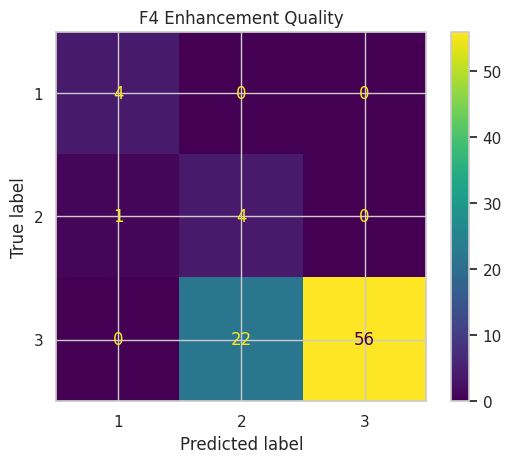

In [14]:
y_true, y_pred = get_ytrue_ypred()
vasari_metric='F4 Enhancement Quality'

print(accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int)))
print(sklearn.metrics.balanced_accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int)))

# sklearn.metrics.balanced_accuracy_score

cm = confusion_matrix(y_true[vasari_metric].values.astype(int), y_pred=y_pred[vasari_metric].values.astype(int),labels=np.unique(y_true[vasari_metric].values.astype(int)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.unique(y_true[vasari_metric].values.astype(int)))
disp.plot()
plt.title(vasari_metric)

In [15]:
y_pred

,filename,OS,Reporter,time_taken_seconds,F1 Tumour Location,F2 Side of Tumour Epicenter,F3 Eloquent Brain,F4 Enhancement Quality,F5 Proportion Enhancing,F6 Proportion nCET,F7 Proportion Necrosis,F8 Cyst(s),F9 Multifocal or Multicentric,F10 T1/FLAIR Ratio,F11 Thickness of enhancing margin,F12 Definition of the Enhancing margin,F13 Definition of the non-enhancing tumour margin,F14 Proportion of Oedema,F16 haemorrhage,F17 Diffusion,F18 Pial invasion,F19 Ependymal Invasion,F20 Cortical involvement,F21 Deep WM invasion,F24 satellites,F25 Calvarial modelling,COMMENTS,F22 nCET Crosses Midline,F23 CET Crosses midline,mode,DataOrigin
0,UCSF-PDGM-0005,NaN,VASARI-auto,4.740290,8,1,NaN,2,4,4,4,NaN,1,NaN,4,NaN,NaN,5,NaN,NaN,NaN,1,1,2,1,NaN,Please note that this software is in beta and ...,2,2,VASARI-auto,HandDrawn
1,UCSF-PDGM-0007,NaN,VASARI-auto,3.610801,2,1,NaN,2,4,3,3,NaN,1,NaN,4,NaN,NaN,5,NaN,NaN,NaN,1,2,2,1,NaN,Please note that this software is in beta and ...,2,2,VASARI-auto,HandDrawn
2,UCSF-PDGM-0029,NaN,VASARI-auto,2.960329,4,3,NaN,2,4,3,3,NaN,1,NaN,4,NaN,NaN,5,NaN,NaN,NaN,1,2,1,1,NaN,Please note that this software is in beta and ...,2,3,VASARI-auto,HandDrawn
3,UCSF-PDGM-0032,NaN,VASARI-auto,4.420870,2,3,NaN,3,5,4,4,NaN,1,NaN,4,NaN,NaN,5,NaN,NaN,NaN,2,2,2,1,NaN,Please note that this software is in beta and ...,2,2,VASARI-auto,HandDrawn
4,UCSF-PDGM-0232,NaN,VASARI-auto,4.102836,1,1,NaN,1,3,3,2,NaN,1,NaN,3,NaN,NaN,5,NaN,NaN,NaN,1,2,1,1,NaN,Please note that this software is in beta and ...,2,2,VASARI-auto,HandDrawn
5,UCSF-PDGM-0243,NaN,VASARI-auto,3.509392,1,3,NaN,2,3,3,3,NaN,2,NaN,4,NaN,NaN,5,NaN,NaN,NaN,1,1,1,1,NaN,Please note that this software is in beta and ...,2,2,VASARI-auto,HandDrawn
6,UCSF-PDGM-0261,NaN,VASARI-auto,4.156628,2,3,NaN,1,3,3,2,NaN,1,NaN,3,NaN,NaN,5,NaN,NaN,NaN,1,2,1,1,NaN,Please note that this software is in beta and ...,2,2,VASARI-auto,HandDrawn
7,UCSF-PDGM-0297,NaN,VASARI-auto,3.987188,4,1,NaN,3,4,4,4,NaN,1,NaN,4,NaN,NaN,5,NaN,NaN,NaN,2,2,2,1,NaN,Please note that this software is in beta and ...,2,3,VASARI-auto,HandDrawn
8,UCSF-PDGM-0336,NaN,VASARI-auto,3.622229,1,3,NaN,3,4,5,5,NaN,1,NaN,4,NaN,NaN,5,NaN,NaN,NaN,2,2,2,2,NaN,Please note that this software is in beta and ...,2,2,VASARI-auto,HandDrawn
9,UCSF-PDGM-0357,NaN,VASARI-auto,3.380949,2,3,NaN,2,4,3,2,NaN,1,NaN,5,NaN,NaN,5,NaN,NaN,NaN,1,1,1,1,NaN,Please note that this software is in beta and ...,2,2,VASARI-auto,HandDrawn


In [16]:
# y_pred

#cortical 72 with cortical_thresh=1000
#ependymal 79 with t_ependymal=5000, ( 3500 looked well calibrated)
#deep wm 74, t_w=100, trying 350 (150 not enough) ###though 350 looked reasonably well calibrated...
# satellites 86 at 20, trying 15 (10 is too much)

In [17]:
    # result = pd.DataFrame(columns=col_names)
    # result.loc[len(result)] = {'filename':file,
    #                            'reporter':'VASARI-auto',
    #                           'time_taken_seconds':time_taken,
    #                           'F1 Tumour Location':F1_dict[vols.iloc[0,0]], #vols.iloc[0,0],
    #                           'F2 Side of Tumour Epicenter':F2_dict[side],
    #                           'F3 Eloquent Brain':np.nan, #unsupported in current version
    #                           'F4 Enhancement Quality':enhancement_quality,
    #                           'F5 Proportion Enhancing':proportion_enhancing_f,
    #                           'F6 Proportion nCET':proportion_nonenhancing_f,
    #                           'F7 Proportion Necrosis':proportion_necrosis_f,
    #                           'F8 Cyst(s)':num_components_ncet_f,
    #                             'F9 Multifocal or Multicentric':f9_multifocal,
    #                            'F10 T1/FLAIR Ratio':np.nan,  #unsupported in current version
    #                            'F11 Thickness of enhancing margin':enhancing_thickness_f,
    #                            'F12 Definition of the Enhancing margin':np.nan,  #unsupported in current version
    #                            'F13 Definition of the non-enhancing tumour margin':np.nan,  #unsupported in current version
    #                            'F14 Proportion of Oedema': proportion_oedema_f,
    #                            'F16 haemorrhage':np.nan,  #unsupported in current version
    #                            'F17 Diffusion':np.nan,  #unsupported in current version
    #                            'F18 Pial invasion':np.nan, #unsupported in current version
    #                            'F19 Ependymal Invasion':ependymal, 
    #                            'F20 Cortical involvement':cortical_lesioned_voxels_f,
    #                            'F21 Deep WM invasion':deep_wm_f, 
    #                            'F22 nCET Crosses Midline':nCET_cross_midline_f,
    #                            'F23 CET Crosses midline':CET_cross_midline_f,
    #                            'F24 satellites':num_components_cet_f, 
    #                            'F25 Calvarial modelling':np.nan, #unsupported in current version
    #                            'COMMENTS':'Please note that this software is in beta and utilises only irrevocably anonymised lesion masks. VASARI features that require source data shall not be derived and return NaN'
    #                           }

In [18]:
balanced_accuracy_dict = {}

for c in all_data.columns:
    vasari_metric=c
    try:
        print(vasari_metric+' '+str(accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int))))
        balanced_accuracy_dict[c]=accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int))
        # balanced_accuracy_dict[c]=sklearn.metrics.balanced_accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int))
            
    except:
        balanced_accuracy_dict[c]=0

del balanced_accuracy_dict['time_taken_seconds']
del balanced_accuracy_dict['OS']
del balanced_accuracy_dict['Reporter']
del balanced_accuracy_dict['filename']
del balanced_accuracy_dict['COMMENTS']
del balanced_accuracy_dict['mode']
del balanced_accuracy_dict['DataOrigin']

del balanced_accuracy_dict['F3 Eloquent Brain']
del balanced_accuracy_dict['F10 T1/FLAIR Ratio']
del balanced_accuracy_dict['F12 Definition of the Enhancing margin']
del balanced_accuracy_dict['F13 Definition of the non-enhancing tumour margin']
del balanced_accuracy_dict['F16 haemorrhage']
del balanced_accuracy_dict['F17 Diffusion']
del balanced_accuracy_dict['F18 Pial invasion']
del balanced_accuracy_dict['F25 Calvarial modelling']
del balanced_accuracy_dict['F8 Cyst(s)']

OS 0.0
time_taken_seconds 0.0
F1 Tumour Location 0.8045977011494253
F2 Side of Tumour Epicenter 0.9655172413793104
F4 Enhancement Quality 0.735632183908046
F5 Proportion Enhancing 0.4942528735632184
F6 Proportion nCET 0.20689655172413793
F7 Proportion Necrosis 0.5172413793103449
F9 Multifocal or Multicentric 0.7011494252873564
F11 Thickness of enhancing margin 0.6781609195402298
F14 Proportion of Oedema 0.3218390804597701
F19 Ependymal Invasion 0.7931034482758621
F20 Cortical involvement 0.7241379310344828
F21 Deep WM invasion 0.735632183908046
F24 satellites 0.8620689655172413


/tmp/ipykernel_3341072/3861281762.py:6: RuntimeWarning: invalid value encountered in cast
  print(vasari_metric+' '+str(accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int))))
/tmp/ipykernel_3341072/3861281762.py:7: RuntimeWarning: invalid value encountered in cast
  balanced_accuracy_dict[c]=accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int))


In [19]:
accuracy_metrics = pd.DataFrame(list(balanced_accuracy_dict.values()),columns=['Neuroradiologist VASARI (GT):VASARI-auto accuracy'])
accuracy_metrics['Feature']=list(balanced_accuracy_dict.keys())
accuracy_metrics['Neuroradiologist VASARI (GT):VASARI-auto agreement']=0
accuracy_metrics['Neuroradiologist VASARI (GT) inter-rater agreement']=0
accuracy_metrics['VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model accuracy']=0
accuracy_metrics['VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model agreement']=0
accuracy_metrics['CKS weight']=None

linears = ['F4 Enhancement Quality','F5 Proportion Enhancing','F6 Proportion nCET','F7 Proportion Necrosis','F14 Proportion of Oedema']

accuracy_metrics.loc[accuracy_metrics['Feature'].isin(linears),'CKS weight']='linear'

In [20]:
for i, row in accuracy_metrics.iterrows():
    metric = row['Feature']
    print(metric)
    
    hand_annotation_vasari_auto = new_dataframe_for_modelling_hand_label[metric].values.astype(int)
    tumour_seg_vasari_auto = new_dataframe_for_modelling_tumour_seg[metric].values.astype(int)

    try:
        radiologist_vasari_only = df[metric].values.astype(int)
    except:
        radiologist_vasari_only = np.zeros(shape=tumour_seg_vasari_auto.shape)

    cks_weight = row['CKS weight']
    hand_segment_accuracy = accuracy_score(y_true=hand_annotation_vasari_auto,y_pred=tumour_seg_vasari_auto)
    hand_segment_agreement = cohen_kappa_score(y1=hand_annotation_vasari_auto,y2=tumour_seg_vasari_auto,weights=cks_weight)
    neuroradiologist_vasari_only_agreement = cohen_kappa_score(y1=radiologist_vasari_only,y2=tumour_seg_vasari_auto,weights=cks_weight)

    accuracy_metrics.loc[accuracy_metrics['Feature']==metric,'Neuroradiologist VASARI (GT):VASARI-auto agreement']=neuroradiologist_vasari_only_agreement
    accuracy_metrics.loc[accuracy_metrics['Feature']==metric,'VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model accuracy']=hand_segment_accuracy
    accuracy_metrics.loc[accuracy_metrics['Feature']==metric,'VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model agreement']=hand_segment_agreement

accuracy_metrics.loc[accuracy_metrics['Neuroradiologist VASARI (GT):VASARI-auto agreement']==0,'Neuroradiologist VASARI (GT):VASARI-auto agreement']=np.nan
accuracy_metrics.loc[accuracy_metrics['Neuroradiologist VASARI (GT):VASARI-auto accuracy']==0,'Neuroradiologist VASARI (GT):VASARI-auto accuracy']=np.nan
accuracy_metrics

F1 Tumour Location
F2 Side of Tumour Epicenter
F4 Enhancement Quality
F5 Proportion Enhancing
F6 Proportion nCET
F7 Proportion Necrosis
F9 Multifocal or Multicentric
F11 Thickness of enhancing margin
F14 Proportion of Oedema
F19 Ependymal Invasion
F20 Cortical involvement
F21 Deep WM invasion
F24 satellites
F22 nCET Crosses Midline
F23 CET Crosses midline


,Neuroradiologist VASARI (GT):VASARI-auto accuracy,Feature,Neuroradiologist VASARI (GT):VASARI-auto agreement,Neuroradiologist VASARI (GT) inter-rater agreement,VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model accuracy,VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model agreement,CKS weight
0,0.804598,F1 Tumour Location,0.748710,0,0.99,0.986389,None
1,0.965517,F2 Side of Tumour Epicenter,0.929553,0,0.99,0.981998,None
2,0.735632,F4 Enhancement Quality,0.467849,0,0.98,0.962784,linear
3,0.494253,F5 Proportion Enhancing,0.385436,0,0.93,0.880546,linear
4,0.206897,F6 Proportion nCET,-0.161406,0,0.95,0.924196,linear
5,0.517241,F7 Proportion Necrosis,0.535481,0,0.95,0.940448,linear
6,0.701149,F9 Multifocal or Multicentric,NaN,0,0.97,0.000000,None
7,0.678161,F11 Thickness of enhancing margin,0.243499,0,1.00,1.000000,None
8,0.321839,F14 Proportion of Oedema,0.018305,0,1.00,1.000000,linear
9,0.793103,F19 Ependymal Invasion,0.516484,0,0.98,0.956044,None


2.4278310890061286e-137


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 84.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 37.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 37.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


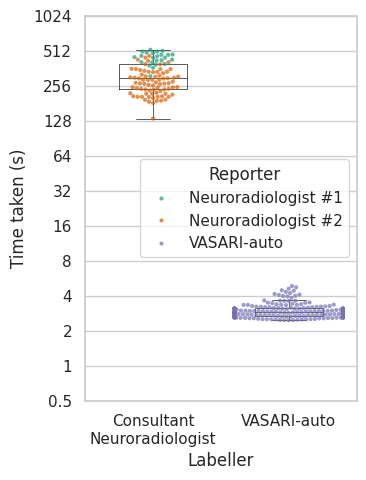

In [21]:
x='mode'
y='time_taken_seconds'

tt = stats.ttest_ind(all_data.loc[all_data[x]=='Consultant\nNeuroradiologist',y].values,all_data.loc[all_data[x]=='VASARI-auto',y].values)
print(tt.pvalue)

plt.figure(figsize=(3.5,5))

ax = sns.boxplot(data=all_data,x=x,y=y,dodge=True,saturation=0.1,fill=False,color='k',fliersize=0,legend=None,linewidth=.5,width=.5)
ax = sns.swarmplot(data=all_data,x=x,y=y,hue='Reporter',dodge=False,size=3,alpha=.7)

# annot = Annotator(ax,[('Consultant\nNeuroradiologist','VASARI-auto')],data=all_data,x=x,y=y)
# annot.configure(text_format='star',log='outside',verbose=2)
# annot.apply_test()

#asplit=True,gap=.1,inner='quart',dodge=True
ax.set(xlabel='Labeller')
ax.set(ylabel='Time taken (s)')
ax.set_yscale('log')
ticks = [0.5,1,2,4,8,16,32,64,128,256,512,1024]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
# ax,test_results = annot.annotate()
# ax.legend(bbox_to_anchor=(1,1))
plt.savefig(figures_out+"efficiency.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"efficiency.svg",dpi=150,bbox_inches='tight')

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 75.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 74.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 7.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 14.0% of the points cannot be place

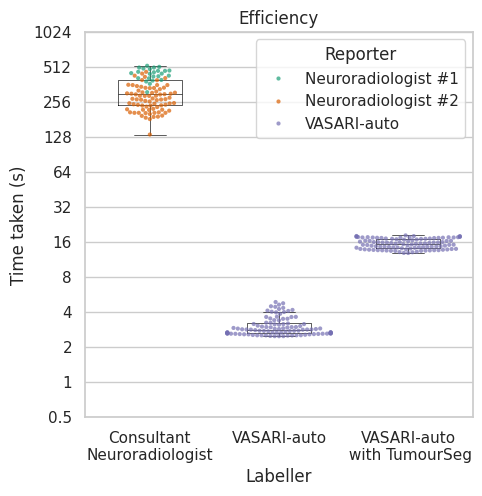

In [22]:
all_data_with_seg = all_data.copy()

import random
all_data_with_seg = all_data.copy()
time_taken_ts = all_data_with_seg.loc[all_data_with_seg['DataOrigin']=='TumourSeg','time_taken_seconds'].values
for t in range(len(time_taken_ts)):
    ts_val = random.uniform(10, 15)
    time_taken_ts[t]+=ts_val
    
all_data_with_seg.loc[all_data_with_seg['DataOrigin']=='TumourSeg','time_taken_seconds']=time_taken_ts
all_data_with_seg.loc[all_data_with_seg['DataOrigin']=='TumourSeg','mode']='VASARI-auto\n with TumourSeg'


x='mode'
y='time_taken_seconds'

# tt = stats.ttest_ind(all_data.loc[all_data[x]=='Consultant\nNeuroradiologist',y].values,all_data.loc[all_data[x]=='VASARI-auto',y].values)
# print(tt.pvalue)

plt.figure(figsize=(5,5))

ax = sns.boxplot(data=all_data_with_seg,x=x,y=y,dodge=True,saturation=0.1,fill=False,color='k',fliersize=0,legend=None,linewidth=.5,width=.5)
ax = sns.swarmplot(data=all_data_with_seg,x=x,y=y,hue='Reporter',dodge=False,size=3,alpha=.7)

# annot = Annotator(ax,[('Consultant\nNeuroradiologist','VASARI-auto')],data=all_data,x=x,y=y)
# annot.configure(text_format='star',log='outside',verbose=2)
# annot.apply_test()

#asplit=True,gap=.1,inner='quart',dodge=True
ax.set(xlabel='Labeller')
ax.set(ylabel='Time taken (s)')
ax.set_yscale('log')
ticks = [0.5,1,2,4,8,16,32,64,128,256,512,1024]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
# ax,test_results = annot.annotate()
# ax.legend(bbox_to_anchor=(1,1))
plt.title('Efficiency')
plt.savefig(figures_out+"efficiency_2.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"efficiency_2.svg",dpi=150,bbox_inches='tight')

In [23]:
v = df.filename.value_counts()
duplicates = df[df.filename.isin(v.index[v.gt(1)])]
duplicate_files = duplicates.loc[duplicates['reporter']=='KPB','filename'].values
drop_cols = ['filename','OS','reporter','time_taken_seconds','F17 Diffusion','F25 Calvarial modelling','COMMENTS','F3 Eloquent Brain','F12 Definition of the Enhancing margin','F13 Definition of the non-enhancing tumour margin']

def flatten(xss):
    return [x for xs in xss for x in xs]

duplicate_files

array(['UCSF-PDGM-0486', 'UPENN-GBM-00159_11', 'UPENN-GBM-00054_11',
       'UPENN-GBM-00031_11', 'UPENN-GBM-00349_11', 'UPENN-GBM-00127_11',
       'UPENN-GBM-00255_11', 'UPENN-GBM-00180_11'], dtype=object)

In [24]:
labeler0=[]
labeler1=[]
reporters = ['KPB','HH']

for d in range(len(duplicate_files)):

    for r in range(len(reporters)):
        reporter_vals = duplicates.loc[(duplicates['filename']==duplicate_files[d])&(duplicates['reporter']==reporters[r])].copy()
        reporter_vals.drop(drop_cols,axis=1,inplace=True)

        if r == 0:
            labeler0.append(reporter_vals.values[0])
        if r == 1:
            labeler1.append(reporter_vals.values[0])
labeler0 = flatten(labeler0)
labeler1 = flatten(labeler1)

In [25]:
reporter1 = pd.DataFrame(labeler0,columns=['VASARI'])
reporter1['Reporter']='#1'
reporter2 = pd.DataFrame(labeler1,columns=['VASARI'])
reporter2['Reporter']='#2'

reporters = pd.concat([reporter1,reporter2])
reporters.head()

,VASARI,Reporter
0,2,#1
1,3,#1
2,2,#1
3,3,#1
4,7,#1


0.49931422796506164


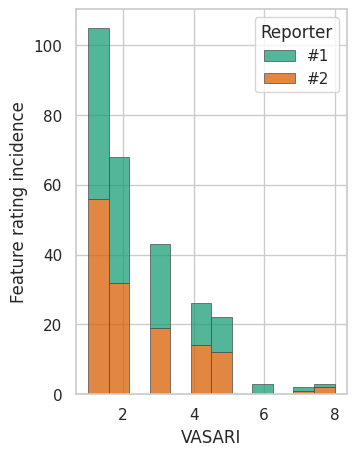

In [26]:
print(cohen_kappa_score(labeler0, labeler1,weights=None))

plt.figure(figsize=(3.5,5))

ax = sns.histplot(data=reporters,x='VASARI',hue='Reporter',multiple='stack',edgecolor=".3",
    linewidth=.5)

# ax.set(xlabel='Compartment')
ax.set(ylabel='Feature rating incidence')

plt.savefig(figures_out+"inter-rater.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"inter-rater.svg",dpi=150,bbox_inches='tight')

In [27]:
loop_these = duplicates[duplicates['filename'].isin(duplicate_files)].copy().reset_index(drop=True)
loop_these_kpb = loop_these.loc[loop_these['reporter']=='KPB']
loop_these_hh = loop_these.loc[loop_these['reporter']=='HH']
loop_these_kpb.sort_values(by='filename',inplace=True)
loop_these_hh.sort_values(by='filename',inplace=True)

for f, row in accuracy_metrics.iterrows():
    cks_weight=row['CKS weight']
    try:
        metric_reporter_1 = loop_these_kpb[row['Feature']].values
        metric_reporter_2 = loop_these_hh[row['Feature']].values
        cks = cohen_kappa_score(metric_reporter_1, metric_reporter_2,weights=cks_weight)
        print(cks)
        
    except:
        print('not quantified')
        cks = np.nan
        
    accuracy_metrics.loc[f,'Neuroradiologist VASARI (GT) inter-rater agreement']=cks

accuracy_metrics.loc[accuracy_metrics['Feature']=='F9 Multifocal or Multicentric','Neuroradiologist VASARI (GT):VASARI-auto agreement']=1
accuracy_metrics.loc[accuracy_metrics['Feature']=='F9 Multifocal or Multicentric','Neuroradiologist VASARI (GT) inter-rater agreement']=1
accuracy_metrics.loc[accuracy_metrics['Feature']=='F9 Multifocal or Multicentric','VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model agreement']=1
accuracy_metrics

0.627906976744186
0.5555555555555556
0.6363636363636364
0.4736842105263158
0.46153846153846156
0.6666666666666667
0.0
-0.02564102564102555
0.5
0.33333333333333337
0.7142857142857143
0.7142857142857143
-0.23076923076923084
not quantified
not quantified


/tmp/ipykernel_3341072/3975566447.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loop_these_kpb.sort_values(by='filename',inplace=True)
/tmp/ipykernel_3341072/3975566447.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loop_these_hh.sort_values(by='filename',inplace=True)


,Neuroradiologist VASARI (GT):VASARI-auto accuracy,Feature,Neuroradiologist VASARI (GT):VASARI-auto agreement,Neuroradiologist VASARI (GT) inter-rater agreement,VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model accuracy,VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model agreement,CKS weight
0,0.804598,F1 Tumour Location,0.748710,0.627907,0.99,0.986389,None
1,0.965517,F2 Side of Tumour Epicenter,0.929553,0.555556,0.99,0.981998,None
2,0.735632,F4 Enhancement Quality,0.467849,0.636364,0.98,0.962784,linear
3,0.494253,F5 Proportion Enhancing,0.385436,0.473684,0.93,0.880546,linear
4,0.206897,F6 Proportion nCET,-0.161406,0.461538,0.95,0.924196,linear
5,0.517241,F7 Proportion Necrosis,0.535481,0.666667,0.95,0.940448,linear
6,0.701149,F9 Multifocal or Multicentric,1.000000,1.000000,0.97,1.000000,None
7,0.678161,F11 Thickness of enhancing margin,0.243499,-0.025641,1.00,1.000000,None
8,0.321839,F14 Proportion of Oedema,0.018305,0.500000,1.00,1.000000,linear
9,0.793103,F19 Ependymal Invasion,0.516484,0.333333,0.98,0.956044,None


In [28]:
accuracy_melt = pd.melt(accuracy_metrics[['Neuroradiologist VASARI (GT):VASARI-auto accuracy','Feature','VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model accuracy']],id_vars=['Feature'])
agreement_melt = pd.melt(accuracy_metrics[['Neuroradiologist VASARI (GT):VASARI-auto agreement','Feature','Neuroradiologist VASARI (GT) inter-rater agreement','VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model agreement']],id_vars=['Feature'])

accuracy_melt.rename(columns={'variable':'Comparison'},inplace=True)
agreement_melt.rename(columns={'variable':'Comparison'},inplace=True)

In [29]:
group='Neuroradiologist VASARI (GT):VASARI-auto accuracy'
new_row0 = {'Feature': 'Mean accuracy', 'Comparison': group,'value':accuracy_melt.loc[accuracy_melt['Comparison']==group,'value'].mean()}
# accuracy_melt.loc[0]=new_row

group='VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model accuracy'
new_row1 = {'Feature': 'Mean accuracy', 'Comparison': group,'value':accuracy_melt.loc[accuracy_melt['Comparison']==group,'value'].mean()}
# accuracy_melt.loc[1]=new_row

accuracy_melt = pd.concat([pd.DataFrame(new_row0,index=[0]),pd.DataFrame(new_row1,index=[0]),accuracy_melt]).reset_index(drop=True)

accuracy_melt.head()
accuracy_melt['value']=accuracy_melt['value']*100

In [30]:
group='Neuroradiologist VASARI (GT):VASARI-auto agreement'
new_row1 = {'Feature': 'Mean agreement', 'Comparison': group,'value':agreement_melt.loc[agreement_melt['Comparison']==group,'value'].mean()}
# agreement_melt.loc[]=new_row

group='Neuroradiologist VASARI (GT) inter-rater agreement'
new_row0 = {'Feature': 'Mean agreement', 'Comparison': group,'value':agreement_melt.loc[agreement_melt['Comparison']==group,'value'].mean()}
# agreement_melt.loc[1]=new_row

group='VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model agreement'
new_row2 = {'Feature': 'Mean agreement', 'Comparison': group,'value':agreement_melt.loc[agreement_melt['Comparison']==group,'value'].mean()}
# agreement_melt.loc[2]=new_row

agreement_melt = pd.concat([pd.DataFrame(new_row0,index=[0]),pd.DataFrame(new_row1,index=[0]),pd.DataFrame(new_row2,index=[0]),agreement_melt]).reset_index(drop=True)

agreement_melt.head()

,Feature,Comparison,value
0,Mean agreement,Neuroradiologist VASARI (GT) inter-rater agree...,0.494401
1,Mean agreement,Neuroradiologist VASARI (GT):VASARI-auto agree...,0.417722
2,Mean agreement,VASARI-auto using Neuroradiologist segmentatio...,0.940641
3,F1 Tumour Location,Neuroradiologist VASARI (GT):VASARI-auto agree...,0.748710
4,F2 Side of Tumour Epicenter,Neuroradiologist VASARI (GT):VASARI-auto agree...,0.929553


/tmp/ipykernel_3341072/64416129.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30,ha='right',rotation_mode='anchor')


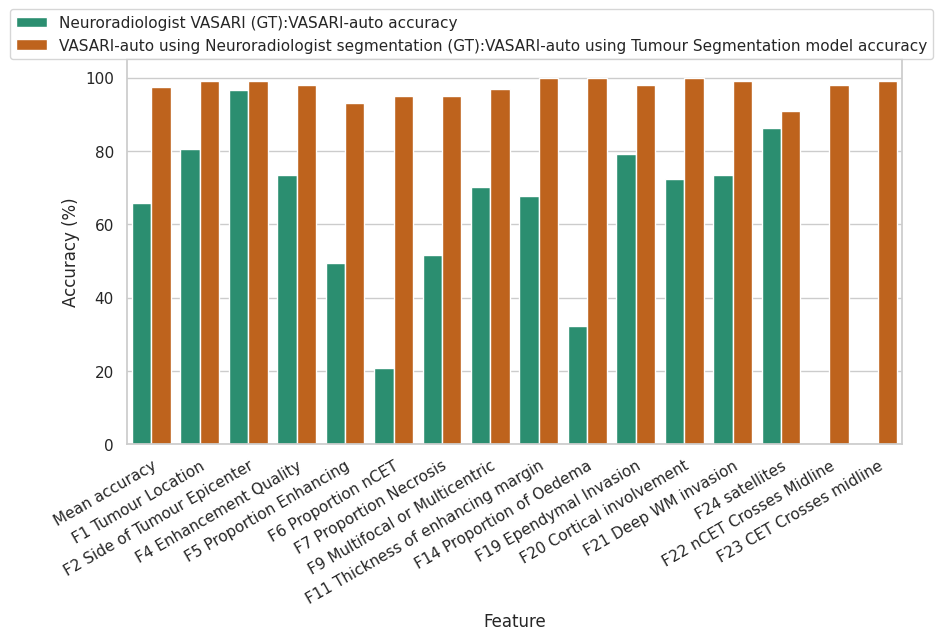

In [31]:
x='Feature'
y='value'
h='Comparison'

plt.figure(figsize=(10,5))

ax = sns.barplot(data=accuracy_melt,x=x,y=y,hue=h)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30,ha='right',rotation_mode='anchor')

# ax.tick_params(axis='x', rotation=45,rotation_mode='anchor')
# ax.set_xticklabels(rotation=40, ha='center')
# ax = sns.swarmplot(data=dice_df_melt,x=x,y=y,hue=h,dodge=True,size=3,alpha=.7)

# ax.set(xlabel='Compartment')
ax.set(ylabel='Accuracy (%)')
plt.legend(bbox_to_anchor= (1.05,1.15))
plt.savefig(figures_out+"accuracy.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"accuracy.svg",dpi=150,bbox_inches='tight')

/tmp/ipykernel_3341072/1155481638.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30,ha='right',rotation_mode='anchor')


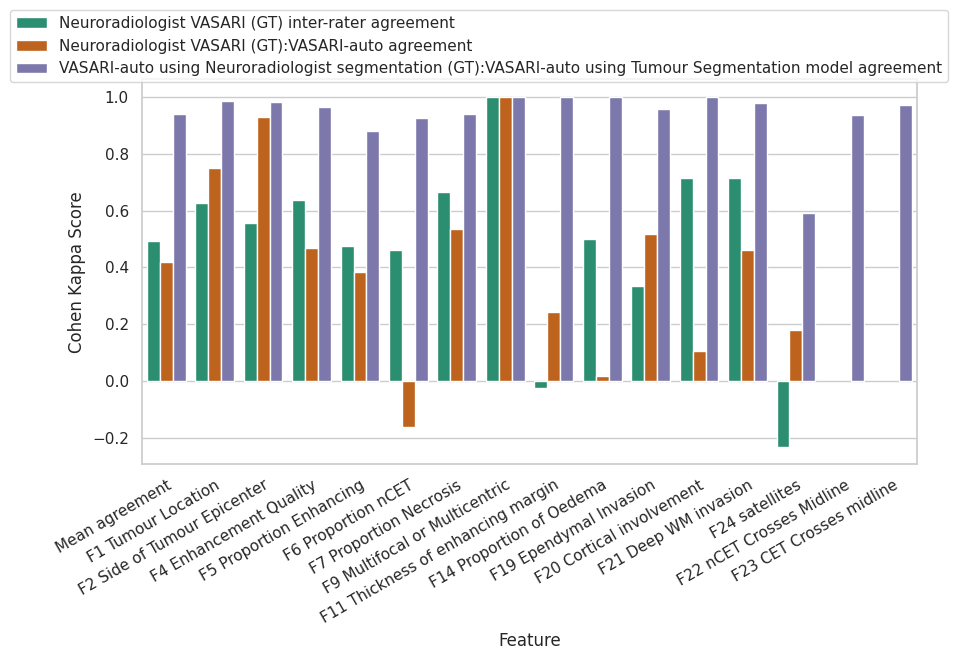

In [32]:
x='Feature'
y='value'
h='Comparison'

plt.figure(figsize=(10,5))

ax = sns.barplot(data=agreement_melt,x=x,y=y,hue=h)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30,ha='right',rotation_mode='anchor')

# ax.tick_params(axis='x', rotation=45,rotation_mode='anchor')
# ax.set_xticklabels(rotation=40, ha='center')
# ax = sns.swarmplot(data=dice_df_melt,x=x,y=y,hue=h,dodge=True,size=3,alpha=.7)

# ax.set(xlabel='Compartment')
ax.set(ylabel='Cohen Kappa Score')
plt.legend(bbox_to_anchor= (1.05,1.2))
plt.savefig(figures_out+"agreement.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"agreement.svg",dpi=150,bbox_inches='tight')

In [33]:
bar_order = ['F1 Tumour Location','F2 Side of Tumour Epicenter','F4 Enhancement Quality','F5 Proportion Enhancing',
            'F6 Proportion nCET','F7 Proportion Necrosis','F9 Multifocal or Multicentric','F11 Thickness of enhancing margin',
             'F14 Proportion of Oedema','F19 Ependymal Invasion','F20 Cortical involvement','F21 Deep WM invasion',
             'F22 nCET Crosses Midline','F23 CET Crosses midline','F24 satellites']

/tmp/ipykernel_3341072/3267517836.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.boxplot(data=agreement_melt.loc[agreement_melt['Feature']!='Mean agreement'],x=h,y=y,hue=h,ax=ax[0,0],order=comparison_order,dodge=False,legend=False,saturation=0.1,fill=False,color='k',fliersize=0,linewidth=.5,width=0.8,hue_order=comparison_order,whis=0)
/tmp/ipykernel_3341072/3267517836.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), rotation=30,ha='right',rotation_mode='anchor')
/tmp/ipykernel_3341072/3267517836.py:41: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.stripplot(data=accuracy_melt.loc[accuracy_melt['Feature']!='Mean accuracy'],x=h,y=y,hue=h,ax=ax[1,0],order=comparison_order,dodge=False,alpha=0.5,legend=False,hue_order=comparison_order,palett

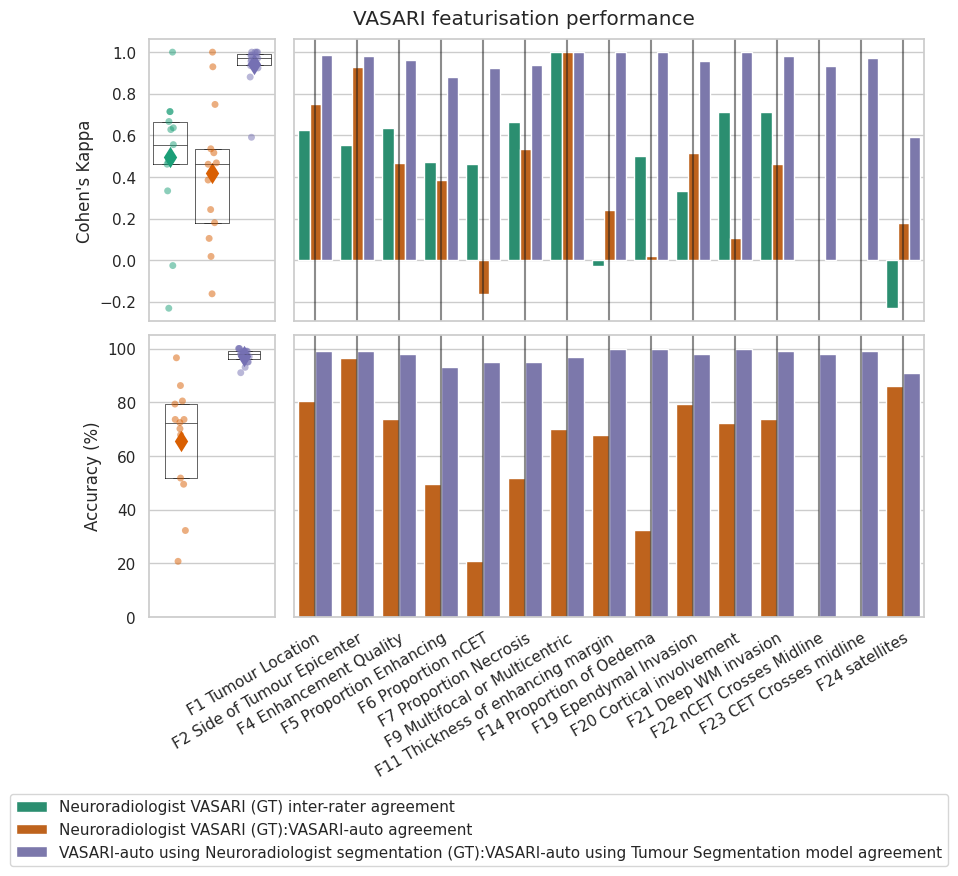

In [281]:
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 5]},figsize=(10,7.5),sharey='row')


x='Feature'
y='value'
h='Comparison'

comparison_order = ['Neuroradiologist VASARI (GT) inter-rater agreement','Neuroradiologist VASARI (GT):VASARI-auto agreement',
                   'VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model agreement']

sns.stripplot(data=agreement_melt.loc[agreement_melt['Feature']!='Mean agreement'],x=h,y=y,hue=h,ax=ax[0,0],order=comparison_order,dodge=False,alpha=0.5,legend=False,hue_order=comparison_order)
sns.boxplot(data=agreement_melt.loc[agreement_melt['Feature']!='Mean agreement'],x=h,y=y,hue=h,ax=ax[0,0],order=comparison_order,dodge=False,legend=False,saturation=0.1,fill=False,color='k',fliersize=0,linewidth=.5,width=0.8,hue_order=comparison_order,whis=0)
sns.pointplot(data=agreement_melt.loc[agreement_melt['Feature']!='Mean agreement'],x=h,y=y,hue=h,ax=ax[0,0],order=comparison_order,dodge=False,errorbar=None,markers="d",markersize=8,linestyle="none",hue_order=comparison_order)
ax[0,0].set_xticks([])
ax[0,0].set_xlabel('')
# ax[0,0].set_ylabel('')

sns.barplot(data=agreement_melt.loc[agreement_melt['Feature']!='Mean agreement'],x=x,y=y,hue=h,ax=ax[0,1],order=bar_order,hue_order=comparison_order)
# sns.pointplot(data=agreement_melt.loc[agreement_melt['Feature']!='Mean agreement'],x=x,y=y,hue=h,ax=ax[0,1],order=bar_order,hue_order=comparison_order,dodge=False,errorbar=None,markers="d",markersize=8,linestyle="none")

ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), rotation=30,ha='right',rotation_mode='anchor')

# ax.set(xlabel='Compartment')
ax[0,0].set(ylabel="Cohen's Kappa")
ax[0,1].legend(bbox_to_anchor= (1.05,-1.65))
ax[0,1].set_xlabel('')
# ax[0,1].set_title('Agreement')
xt = ax[0,1].get_xticks()
for i in xt:
    ax[0,1].axvline(x = i, color = 'k',ls='-',alpha=0.5)
ax[0,1].set_xticks([])
ax[0,1].set_xlabel('')
    
comparison_order = ['Neuroradiologist VASARI (GT):VASARI-auto accuracy','VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model accuracy']
x='Feature'
y='value'
h='Comparison'
# sns.stripplot(data=accuracy_melt.loc[accuracy_melt['Feature']!='Mean accuracy'],x=h,y=y,hue=h,ax=ax[1,0],order=comparison_order,dodge=True,alpha=0.3,legend=False)
# sns.pointplot(data=accuracy_melt.loc[accuracy_melt['Feature']!='Mean accuracy'],x=h,y=y,hue=h,ax=ax[1,0],order=comparison_order,dodge=.8 - .8 / 3,errorbar=None,markers="d",markersize=4,linestyle="none")

sns.stripplot(data=accuracy_melt.loc[accuracy_melt['Feature']!='Mean accuracy'],x=h,y=y,hue=h,ax=ax[1,0],order=comparison_order,dodge=False,alpha=0.5,legend=False,hue_order=comparison_order,palette=sns.color_palette(as_cmap=True)[1:])
sns.boxplot(data=accuracy_melt.loc[accuracy_melt['Feature']!='Mean accuracy'],x=h,y=y,hue=h,ax=ax[1,0],order=comparison_order,dodge=False,legend=False,saturation=0.1,fill=False,color='k',fliersize=0,linewidth=.5,width=0.5,hue_order=comparison_order,whis=0)
sns.pointplot(data=accuracy_melt.loc[accuracy_melt['Feature']!='Mean accuracy'],x=h,y=y,hue=h,ax=ax[1,0],order=comparison_order,dodge=False,errorbar=None,markers="d",markersize=8,linestyle="none",hue_order=comparison_order,palette=sns.color_palette(as_cmap=True)[1:])

ax[1,0].set_xticks([])
ax[1,0].set_xlabel('')

sns.barplot(data=accuracy_melt.loc[accuracy_melt['Feature']!='Mean accuracy'],x=x,y=y,hue=h,ax=ax[1,1],order=bar_order,hue_order=comparison_order,palette=sns.color_palette(as_cmap=True)[1:],legend=False)
# sns.pointplot(data=accuracy_melt.loc[accuracy_melt['Feature']!='Mean accuracy'],x=x,y=y,hue=h,ax=ax[1,1],order=bar_order,hue_order=comparison_order,dodge=False,errorbar=None,markers="d",markersize=8,linestyle="none")


ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=30,ha='right',rotation_mode='anchor')
ax[1,0].set(ylabel='Accuracy (%)')
# ax[1,1].legend(bbox_to_anchor= (1.05,-.65))
ax[1,1].set_xlabel('')
# ax[1,1].set_title('Accuracy')
xt = ax[1,1].get_xticks()
for i in xt:
    ax[1,1].axvline(x = i, color = 'k',ls='-',alpha=0.5)



# ax1.set_box_aspect(1)
# ax2.set_box_aspect(1)
# ax3.set_box_aspect(1)
# ax4.set_box_aspect(1)

# plt.tight_layout()

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=.05)

fig.suptitle('VASARI featurisation performance',y=.92)

plt.savefig(figures_out+"Figure3.png",dpi=300,bbox_inches='tight')
plt.savefig(figures_out+"Figure3.svg",dpi=300,bbox_inches='tight')

In [35]:
enhancing_label=3
nonenhancing_label=1
oedema_label=2
from torch import tensor
from torchmetrics.classification import Dice
dice = Dice(average='micro')
all_molecular_data = pd.read_csv('/mnt/wwn-0x5002538f4132e495/brc3_rsync/NEUROONCOLOGY/DATA/DEEP_TOPOLOGY_OUTPUTS/processed_csv/'+'all_molecular_data.csv',index_col=0)

dice_df = pd.DataFrame(columns=['filename','filename_hand_label','filename_tumour_seg_label','Abnormality','Perilesional signal change','Nonenhancing tumour','Enhancing tumour','Age','Sex'])
dice_df['filename']=neurorad_hand_label_subs
dice_df['filename_hand_label']= new_dataframe_for_modelling_hand_label['filename']
dice_df['filename_tumour_seg_label']= new_dataframe_for_modelling_tumour_seg['filename']

for i, row in tqdm(dice_df.iterrows(),total=len(dice_df)):
    seg_hand_label = np.asanyarray(nib.load(row['filename_hand_label']).dataobj)
    seg_tumour_seg = np.asanyarray(nib.load(row['filename_tumour_seg_label']).dataobj)

    if i==0:
        hand_label_stack = np.zeros(shape=seg_hand_label.shape)
        tumour_seg_stack = np.zeros(shape=seg_hand_label.shape)
    
    #abnormality
    seg_hand_label_abnormality = seg_hand_label.copy()
    seg_hand_label_abnormality[seg_hand_label_abnormality>0]=1
    seg_tumour_seg_abnormality = seg_tumour_seg.copy()
    seg_tumour_seg_abnormality[seg_tumour_seg_abnormality>0]=1
    dice_abnormality = dice(tensor(seg_tumour_seg_abnormality,dtype=int), tensor(seg_hand_label_abnormality,dtype=int))
    hand_label_stack+=seg_hand_label_abnormality
    tumour_seg_stack+=seg_tumour_seg_abnormality
    
    #oedema
    seg_hand_label_oedema = seg_hand_label.copy()
    seg_hand_label_oedema[seg_hand_label_oedema!=oedema_label]=0
    seg_hand_label_oedema[seg_hand_label_oedema>0]=1
    seg_tumour_seg_oedema = seg_tumour_seg.copy()
    seg_tumour_seg_oedema[seg_tumour_seg_oedema!=oedema_label]=0
    seg_tumour_seg_oedema[seg_tumour_seg_oedema>0]=1
    dice_oedema = dice(tensor(seg_tumour_seg_oedema,dtype=int), tensor(seg_hand_label_oedema,dtype=int))
    
    #net
    seg_hand_label_net = seg_hand_label.copy()
    seg_hand_label_net[seg_hand_label_net!=nonenhancing_label]=0
    seg_hand_label_net[seg_hand_label_net>0]=1
    seg_tumour_seg_net = seg_tumour_seg.copy()
    seg_tumour_seg_net[seg_tumour_seg_net!=nonenhancing_label]=0
    seg_tumour_seg_net[seg_tumour_seg_net>0]=1
    dice_net = dice(tensor(seg_tumour_seg_net,dtype=int), tensor(seg_hand_label_net,dtype=int))
    
    #et
    seg_hand_label_et = seg_hand_label.copy()
    seg_hand_label_et[seg_hand_label_et!=enhancing_label]=0
    seg_hand_label_et[seg_hand_label_et>0]=1
    seg_tumour_seg_et = seg_tumour_seg.copy()
    seg_tumour_seg_et[seg_tumour_seg_et!=enhancing_label]=0
    seg_tumour_seg_et[seg_tumour_seg_et>0]=1
    dice_et = dice(tensor(seg_tumour_seg_et,dtype=int), tensor(seg_hand_label_et,dtype=int))

    dice_df.loc[i,'Abnormality']=dice_abnormality.numpy()
    dice_df.loc[i,'Perilesional signal change']=dice_oedema.numpy()
    dice_df.loc[i,'Nonenhancing tumour']=dice_net.numpy()
    dice_df.loc[i,'Enhancing tumour']=dice_et.numpy()

    mrn = row['filename']
    if len(all_molecular_data.loc[all_molecular_data['MRN']==mrn,'Age'])==0 and 'UCSF' in mrn:
        mrn = 'UCSF-PDGM-'+str(int(mrn.split('-')[-1])).zfill(3)
    
    dice_df.loc[i,'Age']=all_molecular_data.loc[all_molecular_data['MRN']==mrn,'Age'].values[0]
    dice_df.loc[i,'Sex']=all_molecular_data.loc[all_molecular_data['MRN']==mrn,'Male'].values[0]

dice_df.loc[dice_df['Sex']==1,'Sex']='Male'
dice_df.loc[dice_df['Sex']==0,'Sex']='Female'
affine = nib.load(row['filename_hand_label']).affine
hand_label_stack_nii = nib.Nifti1Image(hand_label_stack,affine=affine)
tumour_seg_stack_nii = nib.Nifti1Image(tumour_seg_stack,affine=affine)
nib.save(hand_label_stack_nii,figures_out+"hand_label_stack_nii.nii.gz")
nib.save(tumour_seg_stack_nii,figures_out+"tumour_seg_stack_nii.nii.gz")

/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.3-doc-2.g6f55425 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.3-doc-2.g6f55425 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
100%|█████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


In [36]:
dice_df.head()

,filename,filename_hand_label,filename_tumour_seg_label,Abnormality,Perilesional signal change,Nonenhancing tumour,Enhancing tumour,Age,Sex
0,UPENN-GBM-00575_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.99744153,0.99802494,0.9984387,0.996771,76.93,Female
1,UPENN-GBM-00589_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.9989256,0.99859107,0.9995744,0.9991194,80.93,Male
2,UPENN-GBM-00591_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.99903256,0.99891984,0.99991786,0.9998196,75.92,Male
3,UPENN-GBM-00601_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.9968144,0.9966427,0.99945426,0.9989454,59.69,Male
4,UPENN-GBM-00604_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.9991101,0.9989518,0.9994659,0.99878967,62.0,Female


In [37]:
dice_df.rename(columns={'Abnormality':'WT','Perilesional signal change':'PS','Nonenhancing tumour':'NET','Enhancing tumour':'ET'},inplace=True)
dice_df_melt = pd.melt(dice_df,id_vars=['filename','filename_hand_label','filename_tumour_seg_label','Sex','Age'])
dice_df_melt['value']=dice_df_melt['value'].astype(float)
dice_df_melt['Age']=dice_df_melt['Age'].astype(float)
dice_df_melt

,filename,filename_hand_label,filename_tumour_seg_label,Sex,Age,variable,value
0,UPENN-GBM-00575_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Female,76.93,WT,0.997442
1,UPENN-GBM-00589_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,80.93,WT,0.998926
2,UPENN-GBM-00591_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,75.92,WT,0.999033
3,UPENN-GBM-00601_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,59.69,WT,0.996814
4,UPENN-GBM-00604_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Female,62.00,WT,0.999110
5,UPENN-GBM-00611_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,58.09,WT,0.997355
6,UCSF-PDGM-0486,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Female,54.00,WT,0.999228
7,UPENN-GBM-00159_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,63.88,WT,0.997439
8,UPENN-GBM-00054_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Female,39.88,WT,0.995755
9,UCSF-PDGM-0243,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,59.00,WT,0.999543


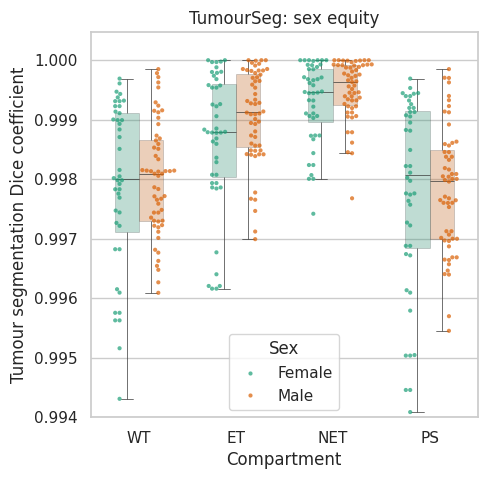

In [38]:
compartment_order = ['WT','ET','NET','PS']

x='variable'
y='value'
h='Sex'

plt.figure(figsize=(5,5))

ax = sns.boxplot(data=dice_df_melt,order=compartment_order,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3))
ax = sns.swarmplot(data=dice_df_melt,order=compartment_order,x=x,y=y,hue=h,dodge=True,size=3,alpha=.7)

ax.set(xlabel='Compartment')
ax.set(ylabel='Tumour segmentation Dice coefficient')
ax.set(ylim=(0.994,None))
yticks = ax.get_yticks() #for next
plt.title('TumourSeg: sex equity')
plt.savefig(figures_out+"dice_equitable_sex.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"dice_equitable_sex.svg",dpi=150,bbox_inches='tight')

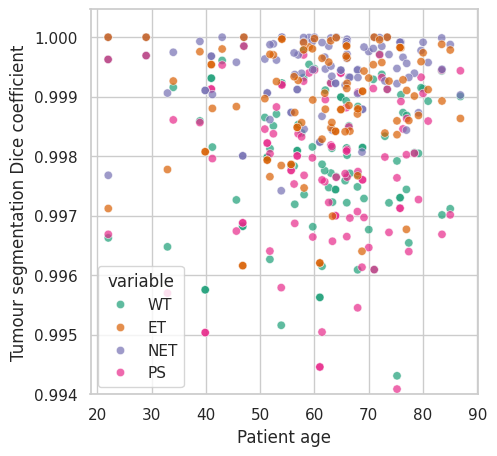

In [39]:
x='Age'
y='value'
h='variable'

plt.figure(figsize=(5,5))

# ax = sns.boxplot(data=dice_df_melt,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3))
ax = sns.scatterplot(data=dice_df_melt,x=x,y=y,hue=h,alpha=.7,hue_order=compartment_order)
ax.set(xlabel='Patient age')
ax.set(ylabel='Tumour segmentation Dice coefficient')
ax.set(ylim=(0.994,None))
plt.savefig(figures_out+"dice_equitable_age.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"dice_equitable_age.svg",dpi=150,bbox_inches='tight')

In [40]:
dice_df_melt['degree']=0
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 360))
dice_df_melt['degree'] = scaler.fit_transform(dice_df_melt['Age'].values[:, None])
dice_df_melt=dice_df_melt.sort_values(by='Age').reset_index(drop=True)
dice_df_melt['Age']=dice_df_melt['Age'].astype(int)
dice_df_melt

,filename,filename_hand_label,filename_tumour_seg_label,Sex,Age,variable,value,degree
0,UCSF-PDGM-0232,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,22,NET,1.000000,0.000000
1,UCSF-PDGM-0232,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,22,PS,0.999626,0.000000
2,UCSF-PDGM-0232,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,22,ET,1.000000,0.000000
3,UCSF-PDGM-0232,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,22,WT,0.999626,0.000000
4,UPENN-GBM-00029_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,22,WT,0.996628,0.166487
5,UPENN-GBM-00029_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,22,NET,0.997680,0.166487
6,UPENN-GBM-00029_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,22,ET,0.997121,0.166487
7,UPENN-GBM-00029_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,22,PS,0.996687,0.166487
8,UCSF-PDGM-0261,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Female,29,NET,1.000000,38.846925
9,UCSF-PDGM-0261,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Female,29,PS,0.999691,38.846925


In [41]:
# ages = list(range(20,90))
# net = []
# et = []
# oed = []
# wt = []

# compartments = ['NET','PS','ET','WT']

# for a in ages:
#     for c in compartments:
#         dc = dice_df_melt.loc[(dice_df_melt['Age']==a)&(dice_df_melt['variable']==c),'value'].mean()

#         if c == 'NET':
#             net.append(dc)

#         if c == 'PS':
#             oed.append(dc)

#         if c == 'ET':
#             et.append(dc)

#         if c == 'WT':
#             wt.append(dc)

ages = [20,30,40,50,60,70,80,90]
net = []
et = []
oed = []
wt = []

compartments = ['NET','PS','ET','WT']

for a in ages:
    for c in compartments:
        dc = dice_df_melt.loc[(dice_df_melt['Age'].between(a-5,a+5))&(dice_df_melt['variable']==c),'value'].mean()

        if c == 'NET':
            net.append(dc)

        if c == 'PS':
            oed.append(dc)

        if c == 'ET':
            et.append(dc)

        if c == 'WT':
            wt.append(dc)

polar_dice = pd.DataFrame(ages,columns=['Age'])
polar_dice['NET']=net
polar_dice['ET']=et
polar_dice['PS']=oed
polar_dice['WT']=wt
polar_dice

,Age,NET,ET,PS,WT
0,20,0.998840,0.998561,0.998157,0.998127
1,30,0.999603,0.999013,0.998000,0.998442
2,40,0.999515,0.999053,0.997642,0.997969
3,50,0.999140,0.998489,0.997913,0.997892
4,60,0.999414,0.998817,0.997778,0.997964
5,70,0.999550,0.999118,0.997589,0.997600
6,80,0.999538,0.999113,0.997756,0.997891
7,90,0.999453,0.999210,0.998225,0.998060


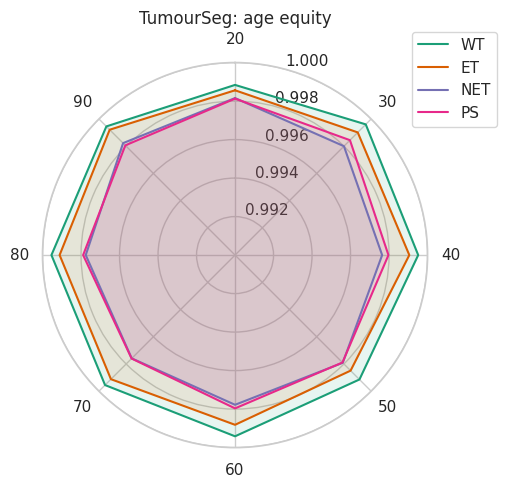

In [42]:
categories = polar_dice['Age']

q1 = polar_dice['NET']
q2 = polar_dice['ET']
q3 = polar_dice['PS']
q4 = polar_dice['WT']

label_loc = np.linspace(start=0, stop=2*np.pi, num=len(q1)+1)

ax=plt.figure(figsize=(5, 5))
ax=plt.subplot(polar=True)

compartment_order_counter=0
for q in [q1, q2, q3, q4]:
    ax.plot(label_loc, np.r_[q, q[0]], label=compartment_order[compartment_order_counter])
    ax.fill(label_loc, np.r_[q, q[0]], alpha=.1,label='_nolegend_')
    compartment_order_counter+=1
plt.title('TumourSeg: age equity')
lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=categories)
ax.set(ylim=(0.99,1.))
# ax.set(yticks=yticks)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_rlabel_position(15)

# ax.set_thetagrids(np.degrees(angles), labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
# plt.legend()

plt.savefig(figures_out+"dice_equitable_age.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"dice_equitable_age.svg",dpi=150,bbox_inches='tight')

plt.show()

In [43]:
from nilearn import plotting

def generate_figure(
    #Necessary file inputs
    file,
    max_coord,
    cmap='reds',
    outpath='/home/jruffle/OneDrive/PhD/TumourCartography/RESULTS/SPM/',
    
    #Figure params
    a=0.75,
    contour_col='white',
    black_bg=True,
    cbar=False,
    # fontsize=12,
    fontsize=14,
    font_bg_col='k',
    fontcolor='white',
    lw=0.25,
    vmax=None,
#     template='/home/jruffle/OneDrive/PhD/usefulbrainthings/MNI/MNI152_T1_0.5mm.nii.gz',
    template = '/home/jruffle/OneDrive/PhD/usefulbrainthings/MNI/MNI152_T1_0.5mm_bet.nii.gz',
    
    save_outputs = True,
    dpi=900,
    
    enable_spm_tissue_seg=False,
    bidirectional=False,
    subplot=False,
    axes=[0,0],
    custom_title='',
    subplot_title='',
    display_mode='ortho'
    
    ):

    if display_mode=='z' and len(max_coord)==3:
        max_coord = [max_coord[-1]]
    
    
    result = np.asanyarray(nib.load(file).dataobj)
    vmin = np.min(result)

    if vmax is not None:
        vmax = np.max(result)
        
        if np.abs(vmin)>np.abs(vmax):
            vmax = np.abs(vmin)

    if subplot:
        display = plotting.plot_stat_map(file,
                                 bg_img = template,
                                 threshold=1, 
                                 annotate=False,
                                 cmap=cmap,
                                 alpha=a,
                                draw_cross=False,
                                 cut_coords=max_coord,
                                 black_bg=black_bg,
                                 colorbar=cbar,
                                 dim='auto',
#                                      vmin = vmin,
                                 vmax = vmax,
                                axes=axes,
                                display_mode=display_mode,
                                         symmetric_cbar=False
                                 )

    # display.add_contours(result_path+mask+'.nii', filled=False, colors=contour_col,linewidths=lw)
    
    # if enable_spm_tissue_seg:
        # display.add_contours('/home/jruffle/OneDrive/PhD/usefulbrainthings/segment_template/braintissue_3label.nii.gz', filled=False, linewidths=lw,levels=[1,2,3],colors='k')

    # if not subplot:
        # display.title(str(test)+' | '+str(test_compartment)+'\n'+
                  # 'Contour mask FWE-p <'+str(min_p)+' | Max T '+str(max_t)+' ~ MNI '+str(max_coord),             
                  # size=fontsize,bgcolor=font_bg_col,color=fontcolor)
    if subplot:
        display.title(custom_title,size=fontsize,bgcolor=font_bg_col,color=fontcolor)
    
    # if not subplot and save_outputs:
        # display.savefig(outpath+str(test)+'_'+str(test_compartment)+'.png',dpi=dpi)
        # display.savefig(outpath+str(test)+'_'+str(test_compartment)+'.svg',dpi=dpi)

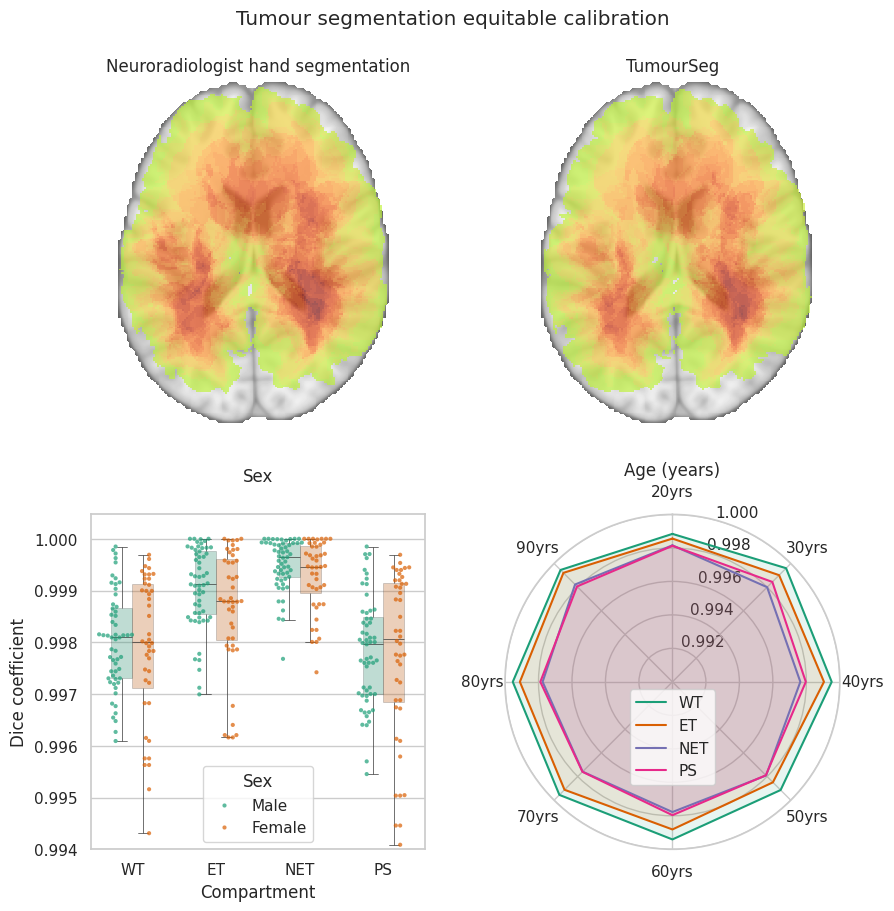

In [280]:
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224, projection = 'polar')


##sex calibration
compartment_order = ['WT','ET','NET','PS']
x='variable'
y='value'
h='Sex'
sns.boxplot(data=dice_df_melt,order=compartment_order,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3),ax=ax3)
sns.swarmplot(data=dice_df_melt,order=compartment_order,x=x,y=y,hue=h,dodge=True,size=3,alpha=.7,ax=ax3)

ax3.set(xlabel='Compartment')
ax3.set(ylabel='Dice coefficient')
ax3.set(ylim=(0.994,None))
yticks = ax3.get_yticks() #for next
ax3.set_title('Sex',y=1.075)

##age calibration
categories = polar_dice['Age'].astype(str)+'yrs'
q1 = polar_dice['NET']
q2 = polar_dice['ET']
q3 = polar_dice['PS']
q4 = polar_dice['WT']
label_loc = np.linspace(start=0, stop=2*np.pi, num=len(q1)+1)

compartment_order_counter=0
for q in [q1, q2, q3, q4]:
    ax4.plot(label_loc, np.r_[q, q[0]], label=compartment_order[compartment_order_counter])
    ax4.fill(label_loc, np.r_[q, q[0]], alpha=.1,label='_nolegend_')
    compartment_order_counter+=1
ax4.set_title('Age (years)')
lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=categories)
ax4.set(ylim=(0.99,1.))
# ax4.set_xticks(labels,fontsize=5)
ax4.set_theta_offset(np.pi / 2)
ax4.set_theta_direction(-1)
ax4.set_rlabel_position(15)
# ax.set_thetagrids(np.degrees(angles), labels)
ax4.legend(loc='upper right', bbox_to_anchor=(.65, .5))
# ax4.set_yticks(size=5)
# ax4.set_xticks(size=5)

z=17
alpha=0.65
generate_figure(file='/home/jruffle/OneDrive/PhD/VASARI/Results/figs_output/hand_label_stack_nii.nii.gz',
                max_coord = (-31,-34,z), #manually selected 
                axes=ax1,
                subplot=True,
                display_mode='z',
                a=alpha,
                cmap='turbo',
                black_bg=False,
                # vmax=24
               )
ax1.set_title('Neuroradiologist hand segmentation')

generate_figure(file='/home/jruffle/OneDrive/PhD/VASARI/Results/figs_output/tumour_seg_stack_nii.nii.gz',
                max_coord = (-31,-34,z), #manually selected 
                axes=ax2,
                subplot=True,
                display_mode='z',
                a=alpha,
                cmap='turbo',
                cbar=False,
                black_bg=False,
                # vmax=1
               )
ax2.set_title('TumourSeg')


ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)
# ax4.set_box_aspect(1)

# plt.tight_layout()

plt.subplots_adjust(wspace=0.15)
plt.subplots_adjust(hspace=0.3)

fig.suptitle('Tumour segmentation equitable calibration',y=.95)

plt.savefig(figures_out+"Figure2.png",dpi=300,bbox_inches='tight')
plt.savefig(figures_out+"Figure2.svg",dpi=300,bbox_inches='tight')

In [510]:
survival_data = all_data[['filename','OS']].dropna()
survival_data.rename(columns={'OS':'Overall survival (days)'},inplace=True)
survival_data['Overall survival (days)'] = np.clip(survival_data['Overall survival (days)'], None, np.percentile(survival_data['Overall survival (days)'],90))
downstream = all_data.merge(survival_data)
downstream

input_cols = ['F1 Tumour Location','F2 Side of Tumour Epicenter','F4 Enhancement Quality','F5 Proportion Enhancing','F6 Proportion nCET','F7 Proportion Necrosis'
              ,'F9 Multifocal or Multicentric','F11 Thickness of enhancing margin','F14 Proportion of Oedema','F19 Ependymal Invasion','F20 Cortical involvement',
              'F21 Deep WM invasion','F24 satellites','Overall survival (days)','DataOrigin','Reporter','filename']

downstream = downstream[input_cols].copy()
downstream_vasari_auto = downstream.loc[(downstream['DataOrigin']=='HandDrawn')&(downstream['Reporter']=='VASARI-auto')]
downstream_vasari_auto.drop_duplicates(subset='filename',inplace=True)

downstream_vasari_auto_tumour_seg = downstream.loc[(downstream['DataOrigin']=='TumourSeg')&(downstream['Reporter']=='VASARI-auto')]
downstream_vasari_auto_tumour_seg.drop_duplicates(subset='filename',inplace=True)

downstream_neurorads = downstream.loc[(downstream['DataOrigin']=='HandDrawn')&(downstream['Reporter']!='Vasari-auto')]
downstream_neurorads.drop_duplicates(subset='filename',inplace=True)

downstream_vasari_auto.reset_index(drop=True,inplace=True)
downstream_neurorads.reset_index(drop=True,inplace=True)
downstream_vasari_auto_tumour_seg.reset_index(drop=True,inplace=True)

/tmp/ipykernel_3341072/3109041563.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downstream_vasari_auto.drop_duplicates(subset='filename',inplace=True)
/tmp/ipykernel_3341072/3109041563.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downstream_vasari_auto_tumour_seg.drop_duplicates(subset='filename',inplace=True)
/tmp/ipykernel_3341072/3109041563.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downstream_neurorads.drop

In [511]:
downstream_vasari_auto_tumour_seg

,F1 Tumour Location,F2 Side of Tumour Epicenter,F4 Enhancement Quality,F5 Proportion Enhancing,F6 Proportion nCET,F7 Proportion Necrosis,F9 Multifocal or Multicentric,F11 Thickness of enhancing margin,F14 Proportion of Oedema,F19 Ependymal Invasion,F20 Cortical involvement,F21 Deep WM invasion,F24 satellites,Overall survival (days),DataOrigin,Reporter,filename
0,2,1,3,5,4,4,1,4,5,2,2,2,1,153.0,TumourSeg,VASARI-auto,UPENN-GBM-00575_11
1,2,3,3,4,4,4,1,4,5,1,2,1,1,26.0,TumourSeg,VASARI-auto,UPENN-GBM-00589_11
2,1,3,2,4,3,3,1,4,5,1,2,1,1,59.0,TumourSeg,VASARI-auto,UPENN-GBM-00591_11
3,2,1,2,4,4,4,1,4,5,1,2,1,1,435.0,TumourSeg,VASARI-auto,UPENN-GBM-00601_11
4,4,3,3,5,5,5,1,4,4,1,2,1,1,234.0,TumourSeg,VASARI-auto,UPENN-GBM-00604_11
5,2,3,3,4,5,5,1,4,5,1,2,2,1,551.0,TumourSeg,VASARI-auto,UPENN-GBM-00611_11
6,2,3,2,3,3,2,1,5,5,1,1,1,1,232.0,TumourSeg,VASARI-auto,UCSF-PDGM-0486
7,2,3,3,5,4,4,1,4,5,1,2,1,1,264.0,TumourSeg,VASARI-auto,UPENN-GBM-00159_11
8,1,2,3,4,4,4,1,4,5,2,2,2,1,412.0,TumourSeg,VASARI-auto,UPENN-GBM-00054_11
9,1,3,2,3,3,3,1,4,5,1,1,1,1,868.9,TumourSeg,VASARI-auto,UCSF-PDGM-0243


In [512]:
downstream_neurorads['filename'].values.all()==downstream_vasari_auto['filename'].values.all()==downstream_vasari_auto_tumour_seg['filename'].values.all()

True

In [513]:
y=downstream_neurorads['Overall survival (days)']
# y = np.clip(y,a_min=0,a_max=1000)
drop_now = ['DataOrigin','Reporter','filename','Overall survival (days)']
downstream_vasari_auto.drop(drop_now,axis=1,inplace=True)
downstream_vasari_auto_tumour_seg.drop(drop_now,axis=1,inplace=True)
downstream_neurorads.drop(drop_now,axis=1,inplace=True)

/tmp/ipykernel_3341072/2804197993.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downstream_vasari_auto.drop(drop_now,axis=1,inplace=True)
/tmp/ipykernel_3341072/2804197993.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downstream_vasari_auto_tumour_seg.drop(drop_now,axis=1,inplace=True)
/tmp/ipykernel_3341072/2804197993.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downstream_neurorads.drop(drop_now,axis=1,inplace=True

In [514]:
for f in downstream_neurorads.columns:
    if f not in linears and f != 'Overall survival (days)':
        print('one-hot')
        print(f)

        # for data_frame in [downstream_neurorads,downstream_vasari_auto]:
        one_hot = pd.get_dummies(downstream_neurorads[f],prefix=f)
        downstream_neurorads = downstream_neurorads.drop(f,axis = 1)
        downstream_neurorads = downstream_neurorads.join(one_hot)

        one_hot = pd.get_dummies(downstream_vasari_auto[f],prefix=f)
        downstream_vasari_auto = downstream_vasari_auto.drop(f,axis = 1)
        downstream_vasari_auto = downstream_vasari_auto.join(one_hot)

        one_hot = pd.get_dummies(downstream_vasari_auto_tumour_seg[f],prefix=f)
        downstream_vasari_auto_tumour_seg = downstream_vasari_auto_tumour_seg.drop(f,axis = 1)
        downstream_vasari_auto_tumour_seg = downstream_vasari_auto_tumour_seg.join(one_hot)

/tmp/ipykernel_3341072/1837551835.py:7: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = pd.get_dummies(downstream_neurorads[f],prefix=f)
/tmp/ipykernel_3341072/1837551835.py:11: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = pd.get_dummies(downstream_vasari_auto[f],prefix=f)
/tmp/ipykernel_3341072/1837551835.py:15: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = pd.get_dummies(downstream_vasari_auto_tumour_seg[f],prefix=f)
/tmp/ipykernel_3341072/1837551835.py:7: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = pd.get_dummies(downstream_ne

one-hot
F1 Tumour Location
one-hot
F2 Side of Tumour Epicenter
one-hot
F9 Multifocal or Multicentric
one-hot
F11 Thickness of enhancing margin
one-hot
F19 Ependymal Invasion
one-hot
F20 Cortical involvement
one-hot
F21 Deep WM invasion
one-hot
F24 satellites


In [515]:
from sklearn.linear_model import HuberRegressor, LinearRegression,RANSACRegressor,TheilSenRegressor
reg_vasari_auto = LinearRegression().fit(downstream_vasari_auto, y)
reg_vasari_auto_tumour_seg = LinearRegression().fit(downstream_vasari_auto_tumour_seg, y)
reg_neurorads = LinearRegression().fit(downstream_neurorads, y)

reg_vasari_auto_prediction = reg_vasari_auto.predict(downstream_vasari_auto)
reg_vasari_auto_tumour_seg_prediction = reg_vasari_auto_tumour_seg.predict(downstream_vasari_auto_tumour_seg)
reg_neurorads_prediction = reg_neurorads.predict(downstream_neurorads)

print('reg_vasari_auto score: '+str(reg_vasari_auto.score(downstream_vasari_auto,y)))
print('reg_vasari_auto_tumour_seg score: '+str(reg_vasari_auto_tumour_seg.score(downstream_vasari_auto_tumour_seg,y)))
print('reg_neurorads score: '+str(reg_neurorads.score(downstream_neurorads,y)))

reg_vasari_auto score: 0.24546596100185158
reg_vasari_auto_tumour_seg score: 0.22662816727958446
reg_neurorads score: 0.20451349366480165


In [516]:
# epsilonfloat, default=1.35
# The parameter epsilon controls the number of samples that should be classified as outliers. The smaller the epsilon, the more robust it is to outliers. Epsilon must be in the range [1, inf).

# max_iterint, default=100
# Maximum number of iterations that scipy.optimize.minimize(method="L-BFGS-B") should run for.

# alphafloat, default=0.0001
# Strength of the squared L2 regularization. Note that the penalty is equal to alpha * ||w||^2. Must be in the range [0, inf).

# warm_startbool, default=False
# This is useful if the stored attributes of a previously used model has to be reused. If set to False, then the coefficients will be rewritten for every call to fit. See the Glossary.

# fit_interceptbool, default=True
# Whether or not to fit the intercept. This can be set to False if the data is already centered around the origin.

# tolfloat, default=1e-05
# The iteration will stop when max{|proj g_i | i = 1, ..., n} <= tol where pg_i is the i-th component of the projected gradient.

In [517]:
e=1.3
iterations=10000
alpha=0.0001

reg_vasari_auto_huber = HuberRegressor(epsilon=e,max_iter=iterations, alpha=alpha).fit(downstream_vasari_auto, y)
reg_vasari_auto_tumour_seg_huber = HuberRegressor(epsilon=e,max_iter=iterations, alpha=alpha).fit(downstream_vasari_auto_tumour_seg, y)
reg_neurorads_huber = HuberRegressor(epsilon=e,max_iter=iterations, alpha=alpha).fit(downstream_neurorads, y)

reg_vasari_auto_prediction_huber = reg_vasari_auto_huber.predict(downstream_vasari_auto)
reg_vasari_auto_tumour_seg_predRANSACRegressoriction_huber = reg_vasari_auto_tumour_seg_huber.predict(downstream_vasari_auto_tumour_seg)
reg_neurorads_prediction_huber = reg_neurorads_huber.predict(downstream_neurorads)

print('reg_vasari_auto score: '+str(reg_vasari_auto_huber.score(downstream_vasari_auto,y)))
print('reg_vasari_auto_tumour_seg score: '+str(reg_vasari_auto_tumour_seg_huber.score(downstream_vasari_auto_tumour_seg,y)))
print('reg_neurorads score: '+str(reg_neurorads_huber.score(downstream_neurorads,y)))

reg_vasari_auto score: 0.21721737534550845
reg_vasari_auto_tumour_seg score: 0.20247221662423287
reg_neurorads score: 0.1389332898428436


In [518]:
# from sklearn.linear_model import HuberRegressor, LinearRegression,RANSACRegressor,TheilSenRegressor
# reg_vasari_auto = TheilSenRegressor().fit(downstream_vasari_auto, y)
# reg_vasari_auto_tumour_seg = TheilSenRegressor().fit(downstream_vasari_auto_tumour_seg, y)
# reg_neurorads = LinearRegression().fit(downstream_neurorads, y)

# reg_vasari_auto_prediction = reg_vasari_auto.predict(downstream_vasari_auto)
# reg_vasari_auto_tumour_seg_prediction = reg_vasari_auto_tumour_seg.predict(downstream_vasari_auto_tumour_seg)
# reg_neurorads_prediction = reg_neurorads.predict(downstream_neurorads)

# print('reg_vasari_auto score: '+str(reg_vasari_auto.score(downstream_vasari_auto,y)))
# print('reg_vasari_auto_tumour_seg score: '+str(reg_vasari_auto_tumour_seg.score(downstream_vasari_auto_tumour_seg,y)))
# print('reg_neurorads score: '+str(reg_neurorads.score(downstream_neurorads,y)))

In [519]:
model_comparison = pd.DataFrame(y,columns=['Overall survival (days)'])
model_comparison['VASARI-auto'+' | R² '+str(np.round(reg_vasari_auto.score(downstream_vasari_auto,y),3))]=reg_vasari_auto_prediction
model_comparison['VASARI-auto with TumourSeg'+' | R² '+str(np.round(reg_vasari_auto_tumour_seg.score(downstream_vasari_auto_tumour_seg,y),3))]=reg_vasari_auto_tumour_seg_prediction
model_comparison['Neuroradiologist'+' | R² '+str(np.round(reg_neurorads.score(downstream_neurorads,y),3))]=reg_neurorads_prediction
model_comparison_melt = pd.melt(model_comparison,id_vars=['Overall survival (days)'])
model_comparison_melt = model_comparison_melt.rename(columns={'variable':'Source of survival prediction','value':'Predicted overall survival (days)'})

<Figure size 500x500 with 0 Axes>

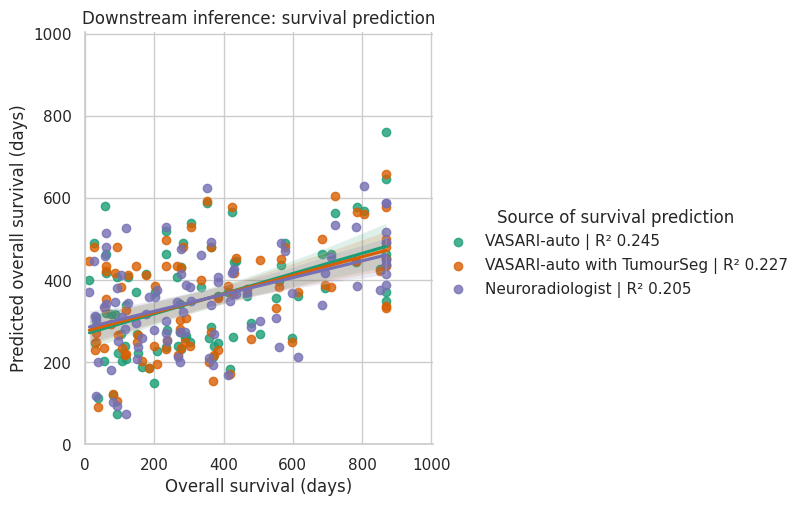

In [520]:
x='Overall survival (days)'
y='Predicted overall survival (days)'
h='Source of survival prediction'

plt.figure(figsize=(5,5))

# ax = sns.boxplot(data=dice_df_melt,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3))
ax = sns.lmplot(data=model_comparison_melt,x=x,y=y,hue=h)

ax.set(xlim=(0,1005))
ax.set(ylim=(0,1005))
plt.title('Downstream inference: survival prediction')
plt.savefig(figures_out+"downstream_prediction.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"downstream_prediction.svg",dpi=150,bbox_inches='tight')

In [521]:
order = ['Consultant\nNeuroradiologist','VASARI-auto','VASARI-auto\n with TumourSeg']
plot_order = ['Neuroradiologist | R² 0.205','VASARI-auto | R² 0.245','VASARI-auto with TumourSeg | R² 0.227']
model_comparison_melt['Source of survival prediction'].value_counts()

VASARI-auto | R² 0.245                   87
VASARI-auto with TumourSeg | R² 0.227    87
Neuroradiologist | R² 0.205              87
Name: Source of survival prediction, dtype: int64

In [522]:
vlines = model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]].reset_index(drop=True)
vlines

# matplotlib.pyplot.vlines
# matplotlib.pyplot.vlines(x, ymin, ymax, colors=None, linestyles='solid', label='', *, data=None, **kwargs)[source]

,Overall survival (days),Source of survival prediction,Predicted overall survival (days)
0,153.0,VASARI-auto with TumourSeg | R² 0.227,265.155022
1,26.0,VASARI-auto with TumourSeg | R² 0.227,481.294184
2,59.0,VASARI-auto with TumourSeg | R² 0.227,422.814767
3,435.0,VASARI-auto with TumourSeg | R² 0.227,454.473082
4,234.0,VASARI-auto with TumourSeg | R² 0.227,231.882949
5,551.0,VASARI-auto with TumourSeg | R² 0.227,331.927889
6,232.0,VASARI-auto with TumourSeg | R² 0.227,499.056861
7,264.0,VASARI-auto with TumourSeg | R² 0.227,434.268258
8,412.0,VASARI-auto with TumourSeg | R² 0.227,385.285163
9,868.9,VASARI-auto with TumourSeg | R² 0.227,577.722131


/tmp/ipykernel_3341072/1089398799.py:3: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],
/tmp/ipykernel_3341072/1089398799.py:21: UserWarning: The palette list has more values (7) than needed (1), which may not be intended.
  sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],
/tmp/ipykernel_3341072/1089398799.py:39: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],


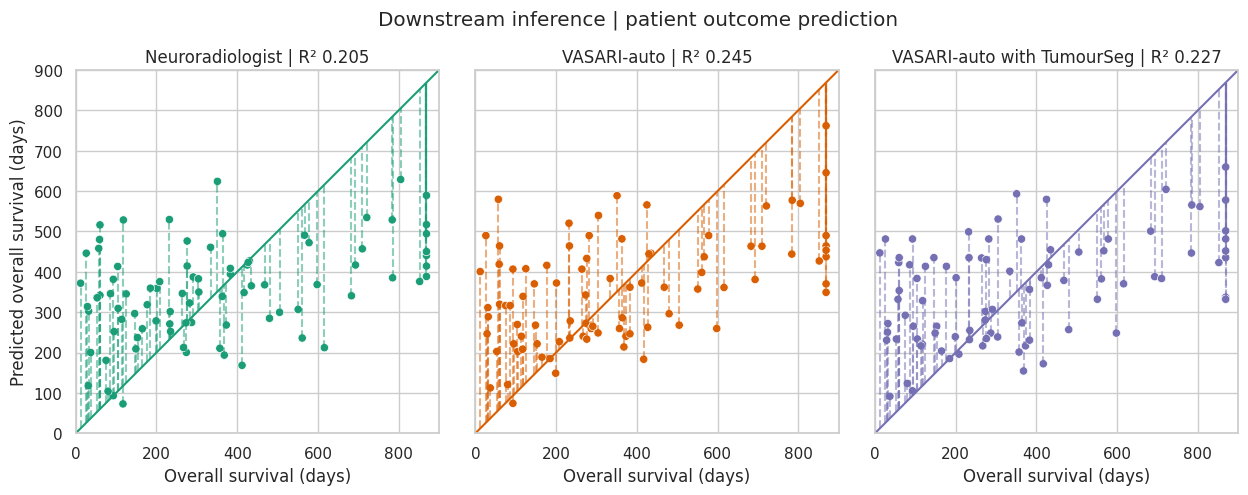

In [528]:
fig, ax = plt.subplots(1, 3,figsize=(15,5),sharey='row')
plot=0
sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],
               palette=sns.color_palette(as_cmap=True)[plot:],legend=False)
ax[plot].set(ylim=(0,900))
ax[plot].set(xlim=(0,900))
ax[plot].set_title(plot_order[plot])
ax[plot].plot([0, 1], [0, 1], transform=ax[plot].transAxes,color=sns.color_palette(as_cmap=True)[plot])
vlines = model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]].reset_index(drop=True)
for v, row in vlines.iterrows():
    if row['Overall survival (days)']>row['Predicted overall survival (days)']:
        ymin = row['Predicted overall survival (days)']
        ymax = row['Overall survival (days)']
    else: 
        ymax = row['Predicted overall survival (days)']
        ymin = row['Overall survival (days)']
    ax[plot].vlines(x=row['Overall survival (days)'],ymin=ymin,ymax=ymax,linestyles='--',alpha=0.5,color=sns.color_palette(as_cmap=True)[plot])
        

plot=1
sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],
               palette=sns.color_palette(as_cmap=True)[plot:],legend=False)
ax[plot].set(ylim=(0,900))
ax[plot].set(xlim=(0,900))
ax[plot].set_title(plot_order[plot])
ax[plot].plot([0, 1], [0, 1], transform=ax[plot].transAxes,color=sns.color_palette(as_cmap=True)[plot])
vlines = model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]].reset_index(drop=True)
for v, row in vlines.iterrows():
    if row['Overall survival (days)']>row['Predicted overall survival (days)']:
        ymin = row['Predicted overall survival (days)']
        ymax = row['Overall survival (days)']
    else: 
        ymax = row['Predicted overall survival (days)']
        ymin = row['Overall survival (days)']
    ax[plot].vlines(x=row['Overall survival (days)'],ymin=ymin,ymax=ymax,linestyles='--',alpha=0.5,color=sns.color_palette(as_cmap=True)[plot])


plot=2
sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],
               palette=sns.color_palette(as_cmap=True)[plot:],legend=False)
ax[plot].set(ylim=(0,900))
ax[plot].set(xlim=(0,900))
ax[plot].set_title(plot_order[plot])
ax[plot].plot([0, 1], [0, 1], transform=ax[plot].transAxes,color=sns.color_palette(as_cmap=True)[plot])
vlines = model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]].reset_index(drop=True)
for v, row in vlines.iterrows():
    if row['Overall survival (days)']>row['Predicted overall survival (days)']:
        ymin = row['Predicted overall survival (days)']
        ymax = row['Overall survival (days)']
    else: 
        ymax = row['Predicted overall survival (days)']
        ymin = row['Overall survival (days)']
    ax[plot].vlines(x=row['Overall survival (days)'],ymin=ymin,ymax=ymax,linestyles='--',alpha=0.5,color=sns.color_palette(as_cmap=True)[plot])

for row in ax:
    row.set_box_aspect(1)

# ax1.set_box_aspect(1)
# ax2.set_box_aspect(1)
# ax3.set_box_aspect(1)
# # ax4.set_box_aspect(1)

# # plt.tight_layout()

plt.subplots_adjust(wspace=0.1)
# plt.subplots_adjust(hspace=0.00)

fig.suptitle("Downstream inference | patient outcome prediction",y=.98)

plt.savefig(figures_out+"Figure6.png",dpi=300,bbox_inches='tight')
plt.savefig(figures_out+"Figure6.svg",dpi=300,bbox_inches='tight')

In [54]:
use_these = ['F1 Tumour Location','F2 Side of Tumour Epicenter','F4 Enhancement Quality','F5 Proportion Enhancing',
            'F6 Proportion nCET','F7 Proportion Necrosis','F9 Multifocal or Multicentric','F11 Thickness of enhancing margin',
            'F14 Proportion of Oedema','F19 Ependymal Invasion','F20 Cortical involvement','F21 Deep WM invasion','F24 satellites']

In [55]:
dice_df['Kappa']=0
dice_df['Accuracy']=0
dummies=False

for i, row in dice_df.iterrows():
    pt = row['filename']
    # print(i)

    neurorads = all_data.loc[(all_data['filename']==pt)&(all_data['mode']=='Consultant\nNeuroradiologist')].reset_index(drop=True).iloc[0,:]
    vasari_auto = all_data.loc[(all_data['filename']==pt)&(all_data['mode']!='Consultant\nNeuroradiologist')].reset_index(drop=True).iloc[0,:]

    if dummies:
        for f in use_these:
            one_hot = pd.get_dummies(neurorads[f],prefix=f)
            neurorads = neurorads.drop(f,axis = 1)
            neurorads = neurorads.join(one_hot)

            one_hot = pd.get_dummies(vasari_auto[f],prefix=f)
            vasari_auto = vasari_auto.drop(f,axis = 1)
            vasari_auto = vasari_auto.join(one_hot)
    
    cks = cohen_kappa_score(neurorads[use_these].values.astype(int), vasari_auto[use_these].values.astype(int),weights='linear')
    acc = accuracy_score(y_true=neurorads[use_these].values.astype(int),y_pred=vasari_auto[use_these].values.astype(int))
    dice_df.loc[i,'Kappa']=cks
    dice_df.loc[i,'Accuracy']=acc*100

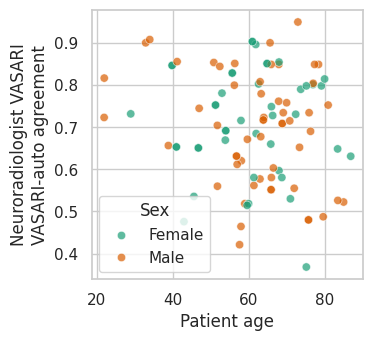

In [56]:
x='Age'
y='Kappa'
h='Sex'

plt.figure(figsize=(3.5,3.5))

# ax = sns.boxplot(data=dice_df_melt,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3))
ax = sns.scatterplot(data=dice_df,x=x,y=y,hue=h,alpha=.7)

ax.set(xlabel='Patient age')
ax.set(ylabel='Neuroradiologist VASARI\nVASARI-auto agreement')
plt.savefig(figures_out+"kappa_equitable_age.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"kappa_equitable_age.svg",dpi=150,bbox_inches='tight')

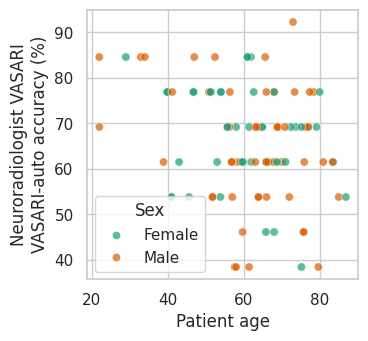

In [57]:
x='Age'
y='Accuracy'
h='Sex'

plt.figure(figsize=(3.5,3.5))

# ax = sns.boxplot(data=dice_df_melt,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3))
ax = sns.scatterplot(data=dice_df,x=x,y=y,hue=h,alpha=.7)

ax.set(xlabel='Patient age')
ax.set(ylabel='Neuroradiologist VASARI\nVASARI-auto accuracy (%)')
plt.savefig(figures_out+"acc_equitable_age.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"acc_equitable_age.svg",dpi=150,bbox_inches='tight')

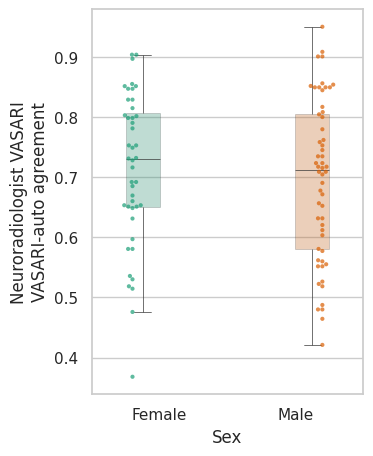

In [58]:
x='Sex'
y='Kappa'
h='Sex'

plt.figure(figsize=(3.5,5))

ax = sns.boxplot(data=dice_df,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3))
ax = sns.swarmplot(data=dice_df,x=x,y=y,hue=h,dodge=True,size=3,alpha=.7)

ax.set(ylabel='Neuroradiologist VASARI\nVASARI-auto agreement')

# ax.set(xlabel='Compartment')
# ax.set(ylabel='Tumour segmentation Dice coefficient')
plt.savefig(figures_out+"kappa_equitable_sex.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"kappa_equitable_sex.svg",dpi=150,bbox_inches='tight')

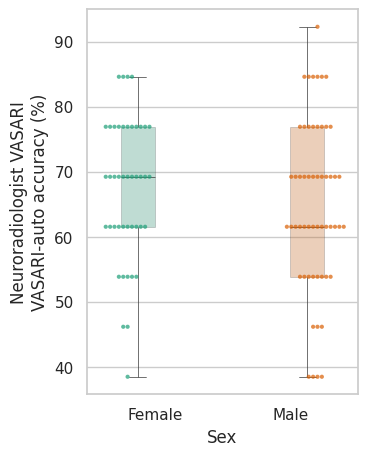

In [59]:
x='Sex'
y='Accuracy'
h='Sex'

plt.figure(figsize=(3.5,5))

ax = sns.boxplot(data=dice_df,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3))
ax = sns.swarmplot(data=dice_df,x=x,y=y,hue=h,dodge=True,size=3,alpha=.7)

ax.set(ylabel='Neuroradiologist VASARI\nVASARI-auto accuracy (%)')

# ax.set(xlabel='Compartment')
# ax.set(ylabel='Tumour segmentation Dice coefficient')
plt.savefig(figures_out+"kappa_equitable_sex.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"kappa_equitable_sx.svg",dpi=150,bbox_inches='tight')

In [530]:
import random
def simulate_timecourse(epochs=52,lower_lim=30,upper_lim=75,tps_ll=1,tps_ul=5,pay_ll=1,pay_ul=5):
    epoch = []
    cost = []
    time = []
    load = []

    cumulative_cost = []
    cumulative_time = []
    cumulative_patient_load = []

    for e in range(epochs):
        epoch.append(e)

        #simulate an MDT load
        mdt_load = random.randint(lower_lim, upper_lim)
        load.append(mdt_load)

        #quantify_time_taken
        time_taken=0
        for p in range(mdt_load):
            time_taken += random.uniform(tps_ll, tps_ul)
        time.append(time_taken)

        #quantify cost
        rate = random.uniform(pay_ll, pay_ul)
        total_cost = rate * time_taken
        cost.append(total_cost)

        #on epoch end
        if e==0:
            c_cost = total_cost
            c_time = time_taken
            c_mdt_load = mdt_load

        if e>0:
            c_cost = total_cost+cumulative_cost[-1]
            c_time = time_taken+cumulative_time[-1]
            c_mdt_load = mdt_load+cumulative_patient_load[-1]
            
        cumulative_cost.append(c_cost)
        cumulative_time.append(c_time)
        cumulative_patient_load.append(c_mdt_load)

    df = pd.DataFrame(epoch,columns=['Epoch'])
    df['Cost (£)']=cost
    df['Time (s)']=time
    df['Patient load']=load
    df['Cumulative cost (£)']=cumulative_cost
    df['Cumulative time (s)']=cumulative_time
    df['Cumulative patient load']=cumulative_patient_load

    return df

In [531]:
#simulated economic_model 
# https://www.nhsemployers.org/system/files/2023-08/Pay%20and%20Conditions%20Circular%20%28MD%29%204-2023%20FINAL_0.pdf
#based on BMA pay circular
hourly_rate = 112356/(52*40) #in pounds
hourly_rate_ll = 93666/(52*40)
hourly_rate_ul = 126281/(52*40)
# second_rate = (hourly_rate/60)/60
second_rate_ll = (hourly_rate_ll/60)/60
second_rate_ul = (hourly_rate_ul/60)/60
time_per_scan_ll_val = df['time_taken_seconds'].astype(float).describe()['min']
time_per_scan_ul_val = df['time_taken_seconds'].astype(float).describe()['max']

radiologist_timecourse = simulate_timecourse(epochs=(52*3),tps_ll=time_per_scan_ll_val,tps_ul=time_per_scan_ul_val,pay_ll=second_rate_ll,pay_ul=second_rate_ul)
radiologist_timecourse['Cumulative time (hrs)']=radiologist_timecourse['Cumulative time (s)']/60/60
radiologist_timecourse['Labeller']='Consultant Neuroradiologist'
radiologist_timecourse.head()

,Epoch,Cost (£),Time (s),Patient load,Cumulative cost (£),Cumulative time (s),Cumulative patient load,Cumulative time (hrs),Labeller
0,0,354.195345,24087.608718,74,354.195345,24087.608718,74,6.691002,Consultant Neuroradiologist
1,1,243.061956,15172.267677,48,597.257301,39259.876395,122,10.905521,Consultant Neuroradiologist
2,2,261.439338,18747.000010,55,858.696639,58006.876405,177,16.113021,Consultant Neuroradiologist
3,3,307.946773,24117.885671,73,1166.643413,82124.762076,250,22.812434,Consultant Neuroradiologist
4,4,309.533574,20899.635888,57,1476.176987,103024.397964,307,28.617888,Consultant Neuroradiologist


In [532]:
#simulated energy use model
# https://www.sust-it.net/energy-calculator.php
hourly_rate = 0.35 #in pounds
hourly_rate_ll = hourly_rate/2
hourly_rate_ul = hourly_rate*2
# second_rate = (hourly_rate/60)/60
second_rate_ll = (hourly_rate_ll/60)/60
second_rate_ul = (hourly_rate_ul/60)/60
time_per_scan_ll_val = all_data_with_seg.loc[all_data_with_seg['mode']=='VASARI-auto\n with TumourSeg','time_taken_seconds'].astype(float).describe()['min']
time_per_scan_ul_val = all_data_with_seg.loc[all_data_with_seg['mode']=='VASARI-auto\n with TumourSeg','time_taken_seconds'].astype(float).describe()['max']

print(second_rate_ll)
vasari_auto_tumour_seg_timecourse = simulate_timecourse(epochs=(52*3),tps_ll=time_per_scan_ll_val,tps_ul=time_per_scan_ul_val,pay_ll=second_rate_ll,pay_ul=second_rate_ul)
vasari_auto_tumour_seg_timecourse['Cumulative time (hrs)']=vasari_auto_tumour_seg_timecourse['Cumulative time (s)']/60/60
vasari_auto_tumour_seg_timecourse['Labeller']='VASARI-auto with TumourSeg'
vasari_auto_tumour_seg_timecourse.head()

4.861111111111111e-05


,Epoch,Cost (£),Time (s),Patient load,Cumulative cost (£),Cumulative time (s),Cumulative patient load,Cumulative time (hrs),Labeller
0,0,0.150917,888.656222,56,0.150917,888.656222,56,0.246849,VASARI-auto with TumourSeg
1,1,0.188625,993.307298,63,0.339542,1881.963520,119,0.522768,VASARI-auto with TumourSeg
2,2,0.073795,695.756433,45,0.413337,2577.719953,164,0.716033,VASARI-auto with TumourSeg
3,3,0.142253,1091.612445,71,0.555590,3669.332398,235,1.019259,VASARI-auto with TumourSeg
4,4,0.095256,591.019783,38,0.650847,4260.352181,273,1.183431,VASARI-auto with TumourSeg


In [533]:

#simulated energy use model
# https://www.sust-it.net/energy-calculator.php
hourly_rate = 0.35 #in pounds
hourly_rate_ll = hourly_rate/2
hourly_rate_ul = hourly_rate*2
# second_rate = (hourly_rate/60)/60
second_rate_ll = (hourly_rate_ll/60)/60
second_rate_ul = (hourly_rate_ul/60)/60
time_per_scan_ll_val = all_data_with_seg.loc[all_data_with_seg['mode']=='VASARI-auto','time_taken_seconds'].astype(float).describe()['min']
time_per_scan_ul_val = all_data_with_seg.loc[all_data_with_seg['mode']=='VASARI-auto','time_taken_seconds'].astype(float).describe()['max']

vasari_auto_timecourse = simulate_timecourse(epochs=(52*3),tps_ll=time_per_scan_ll_val,tps_ul=time_per_scan_ul_val,pay_ll=second_rate_ll,pay_ul=second_rate_ul)
vasari_auto_timecourse['Cumulative time (hrs)']=vasari_auto_timecourse['Cumulative time (s)']/60/60
vasari_auto_timecourse['Labeller']='VASARI-auto'
vasari_auto_timecourse.head()

,Epoch,Cost (£),Time (s),Patient load,Cumulative cost (£),Cumulative time (s),Cumulative patient load,Cumulative time (hrs),Labeller
0,0,0.012630,176.112210,48,0.012630,176.112210,48,0.048920,VASARI-auto
1,1,0.014394,223.064049,61,0.027024,399.176258,109,0.110882,VASARI-auto
2,2,0.012102,186.619768,51,0.039126,585.796026,160,0.162721,VASARI-auto
3,3,0.021936,241.948387,68,0.061062,827.744414,228,0.229929,VASARI-auto
4,4,0.029092,228.426546,65,0.090155,1056.170959,293,0.293381,VASARI-auto


In [534]:
timecourse = pd.concat([radiologist_timecourse,vasari_auto_tumour_seg_timecourse,vasari_auto_timecourse])
# timecourse['Cumulative time (hrs)']=np.log(timecourse['Cumulative time (hrs)'])

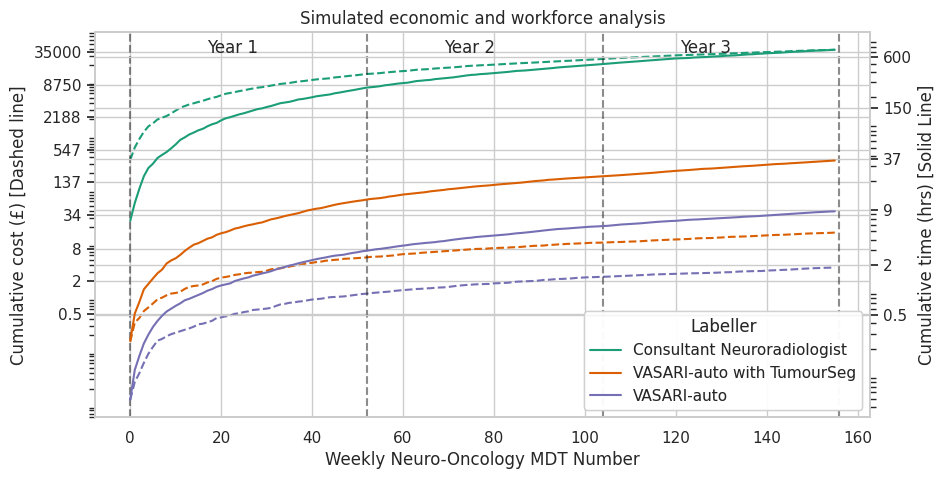

In [535]:
plt.figure(figsize=(10,5))

g = sns.lineplot(data=timecourse, color="g",x='Epoch',y='Cumulative cost (£)',hue='Labeller',linestyle='--')
g2 = sns.lineplot(data=timecourse, color="b",x='Epoch',y='Cumulative time (hrs)',ax=g.axes.twinx(),hue='Labeller')
g.set(xlabel='Neuro-oncology MDT number')
g.axvline(x = 0, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
g.axvline(x = 52, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
g.axvline(x = 52*2, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
g.axvline(x = 52*3, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
g.set_yscale('log')
ticks = [.5,2,8,34,137,547,2188,8750,35000]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g2.set_yscale('log')
ticks = [.5,2,9,37,150,600]
g2.set_yticks(ticks)
g2.set_yticklabels(ticks)

g.set(xlabel='Weekly Neuro-Oncology MDT Number')
g.set(title='Simulated economic and workforce analysis')
g.set(ylabel='Cumulative cost (£) [Dashed line]')
g2.set(ylabel='Cumulative time (hrs) [Solid Line]')

g.annotate('Year 1',xy=(17,34000))
g.annotate('Year 2',xy=((52+17),34000))
g.annotate('Year 3',xy=((52+52+17),34000))

# plt.title('Efficiency')

plt.savefig(figures_out+"simulated_timecourse.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"simulated_timecourse.svg",dpi=150,bbox_inches='tight')

In [536]:
# fig, ax = plt.subplots(1,1)
# # dummy plots, just to get the Path objects
# a = ax.scatter([1,2],[3,4], marker='s')
# b = ax.scatter([1,2],[3,4], marker='^')
# square_mk, = a.get_paths()
# triangle_up_mk, = b.get_paths()
# a.remove()
# b.remove()


# y='mode'
# x='time_taken_seconds'
# order = ['Consultant\nNeuroradiologist','VASARI-auto','VASARI-auto\n with TumourSeg']
# ax = sns.swarmplot(data=all_data_with_seg,x=x,y=y,order=order,hue=y,dodge=False,size=3,alpha=.7)
# collections = ax.collections
# unique_colors = np.unique(collections[0].get_facecolors(), axis=0)
# markers = [triangle_up_mk, square_mk]  # this array must be at least as large as the number of unique colors
# for collection in collections:
#     paths = []
#     for current_color in collection.get_facecolors():
#         for possible_marker,possible_color in zip(markers, unique_colors):
#             if np.array_equal(current_color,possible_color):
#                 paths.append(possible_marker)
#                 break
#     collection.set_paths(paths)
# #update legend
# # ax.legend(collections[-2:],pd.unique(tips.sex))  


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 91.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 81.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 21.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 23.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


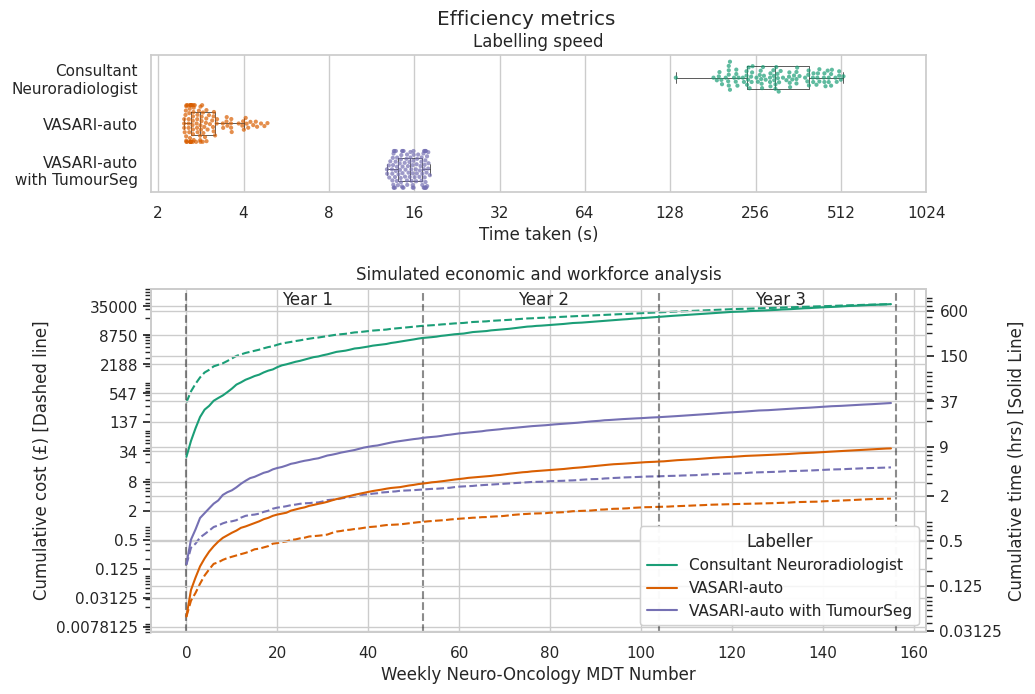

In [541]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 5]},figsize=(10,7.5))

y='mode'
x='time_taken_seconds'
order = ['Consultant\nNeuroradiologist','VASARI-auto','VASARI-auto\n with TumourSeg']
# tt = stats.ttest_ind(all_data.loc[all_data[x]=='Consultant\nNeuroradiologist',y].values,all_data.loc[all_data[x]=='VASARI-auto',y].values)
# print(tt.pvalue)

sns.boxplot(data=all_data_with_seg,x=x,y=y,order=order,dodge=True,saturation=0.1,fill=False,color='k',fliersize=0,legend=None,linewidth=.5,width=.5,ax=ax[0])
sns.swarmplot(data=all_data_with_seg,x=x,y=y,order=order,hue=y,dodge=False,size=3,alpha=.7,ax=ax[0])

# annot = Annotator(ax,[('Consultant\nNeuroradiologist','VASARI-auto')],data=all_data,x=x,y=y)
# annot.configure(text_format='star',log='outside',verbose=2)
# annot.apply_test()

#asplit=True,gap=.1,inner='quart',dodge=True
ax[0].set(ylabel='')
ax[0].set(xlabel='Time taken (s)')
ax[0].set_xscale('log')
ticks = [2,4,8,16,32,64,128,256,512,1024]
ax[0].set_xticks(ticks)
ax[0].set_xticklabels(ticks)
# ax,test_results = annot.annotate()
# ax.legend(bbox_to_anchor=(1,1))
ax[0].set_title('Labelling speed')
# plt.savefig(figures_out+"efficiency_2.png",dpi=150,bbox_inches='tight')
# plt.savefig(figures_out+"efficiency_2.svg",dpi=150,bbox_inches='tight')

order = ['Consultant Neuroradiologist','VASARI-auto','VASARI-auto with TumourSeg']
sns.lineplot(data=timecourse, color="g",x='Epoch',y='Cumulative cost (£)',hue='Labeller',linestyle='--',ax=ax[1],hue_order=order)
g2=ax[1].axes.twinx()
sns.lineplot(data=timecourse, color="b",x='Epoch',y='Cumulative time (hrs)',ax=g2,hue='Labeller',hue_order=order)
ax[1].set(xlabel='Neuro-oncology MDT number')
ax[1].axvline(x = 0, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
ax[1].axvline(x = 52, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
ax[1].axvline(x = 52*2, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
ax[1].axvline(x = 52*3, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
ax[1].set_yscale('log')
ticks = [0.0078125,0.03125,.125,.5,2,8,34,137,547,2188,8750,35000]
ax[1].set_yticks(ticks)
ax[1].set_yticklabels(ticks)

g2.set_yscale('log')
ticks2 = [0.03125,.125,.5,2,9,37,150,600]
g2.set_yticks(ticks2)
g2.set_yticklabels(ticks2)

ax[1].set(xlabel='Weekly Neuro-Oncology MDT Number')
ax[1].set(title='Simulated economic and workforce analysis')
ax[1].set(ylabel='Cumulative cost (£) [Dashed line]')
g2.set(ylabel='Cumulative time (hrs) [Solid Line]')

ax[1].annotate('Year 1',xy=(21,38000),zorder=1)
ax[1].annotate('Year 2',xy=((52+21),38000),zorder=1)
ax[1].annotate('Year 3',xy=((52+52+21),38000),zorder=1)

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=.4)

fig.suptitle('Efficiency metrics',y=.94)

plt.savefig(figures_out+"Figure4.png",dpi=300,bbox_inches='tight')
plt.savefig(figures_out+"Figure4.svg",dpi=300,bbox_inches='tight')

In [140]:
dice_df['Kappa']=0
dice_df['Accuracy']=0
dice_df['VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model Kappa']=0

# 'Neuroradiologist VASARI (GT):VASARI-auto accuracy','VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model accuracy']

dummies=False

for i, row in dice_df.iterrows():
    pt = row['filename']
    # print(i)

    neurorads = all_data.loc[(all_data['filename']==pt)&(all_data['mode']=='Consultant\nNeuroradiologist')].reset_index(drop=True).iloc[0,:]
    vasari_auto = all_data.loc[(all_data['filename']==pt)&(all_data['mode']!='Consultant\nNeuroradiologist')].reset_index(drop=True).iloc[0,:]

    vasari_auto_tumour_seg=all_data.loc[(all_data['filename']==pt)&(all_data['DataOrigin']=='TumourSeg')].reset_index(drop=True).iloc[0,:]
    vasari_auto_only=all_data.loc[(all_data['filename']==pt)&(all_data['DataOrigin']=='HandDrawn')&(all_data['mode']!='Consultant\nNeuroradiologist')].reset_index(drop=True).iloc[0,:]
    
    if dummies:
        for f in use_these:
            one_hot = pd.get_dummies(neurorads[f],prefix=f)
            neurorads = neurorads.drop(f,axis = 1)
            neurorads = neurorads.join(one_hot)

            one_hot = pd.get_dummies(vasari_auto[f],prefix=f)
            vasari_auto = vasari_auto.drop(f,axis = 1)
            vasari_auto = vasari_auto.join(one_hot)

            one_hot = pd.get_dummies(vasari_auto_tumour_seg[f],prefix=f)
            vasari_auto_tumour_seg = vasari_auto_tumour_seg.drop(f,axis = 1)
            vasari_auto_tumour_seg = vasari_auto_tumour_seg.join(one_hot)


            one_hot = pd.get_dummies(vasari_auto_only[f],prefix=f)
            vasari_auto_only = vasari_auto_only.drop(f,axis = 1)
            vasari_auto_only = vasari_auto_only.join(one_hot)
    
    
    cks = cohen_kappa_score(neurorads[use_these].values.astype(int), vasari_auto[use_these].values.astype(int),weights='linear')
    acc = accuracy_score(y_true=neurorads[use_these].values.astype(int),y_pred=vasari_auto[use_these].values.astype(int))

    cks_vasari_auto = cohen_kappa_score(vasari_auto_tumour_seg[use_these].values.astype(int), vasari_auto_only[use_these].values.astype(int),weights='linear')
    
    dice_df.loc[i,'Kappa']=cks
    dice_df.loc[i,'Accuracy']=acc*100
    dice_df.loc[i,'VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model Kappa']=cks_vasari_auto

In [144]:
# dice_df['VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model Kappa'].value_counts()

In [132]:
# dice_df['Age']=dice_df['Age'].astype(float)
# ages = [20,30,40,50,60,70,80,90]
# kappa_m = []
# kappa_f = []
# acc_m = []
# acc_f = []

# compartments = ['Female','Male']

# for a in ages:
#     for c in compartments:
#         k = dice_df.loc[(dice_df['Age'].between(a-10,a+10))&(dice_df['Sex']==c),'Kappa'].mean()
#         a = dice_df.loc[(dice_df['Age'].between(a-10,a+10))&(dice_df['Sex']==c),'Accuracy'].mean()

#         if c == 'Female':
#             kappa_f.append(k)
#             acc_f.append(a)

#         if c == 'Male':
#             kappa_m.append(k)
#             acc_m.append(a)

# polar_equity = pd.DataFrame(ages,columns=['Age'])
# polar_equity["Cohen's Kappa - Female"]=kappa_f
# polar_equity["Cohen's Kappa - Male"]=kappa_m
# polar_equity["Accuracy - Female"]=acc_f
# polar_equity["Accuracy - Male"]=acc_m
# polar_equity

,Age,Cohen's Kappa - Female,Cohen's Kappa - Male,Accuracy - Female
0,20,0.731959,0.652509,60.139860
1,30,0.808692,0.675564,63.461538
2,40,0.664290,0.670371,62.370062
3,50,0.668678,0.665334,61.965812
4,60,0.735719,0.694530,64.423077
5,70,0.730302,0.667320,61.990950
6,80,0.691263,0.682899,63.348416
7,90,0.698223,0.682899,63.348416


In [199]:
dice_df

,filename,filename_hand_label,filename_tumour_seg_label,WT,PS,NET,ET,Age,Sex,Kappa,Accuracy,VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model Kappa
0,UPENN-GBM-00575_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.99744153,0.99802494,0.9984387,0.996771,76.93,Female,0.801527,69.230769,1.000000
1,UPENN-GBM-00589_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.9989256,0.99859107,0.9995744,0.9991194,80.93,Male,0.752852,61.538462,1.000000
2,UPENN-GBM-00591_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.99903256,0.99891984,0.99991786,0.9998196,75.92,Male,0.734694,61.538462,1.000000
3,UPENN-GBM-00601_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.9968144,0.9966427,0.99945426,0.9989454,59.69,Male,0.671480,46.153846,1.000000
4,UPENN-GBM-00604_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.9991101,0.9989518,0.9994659,0.99878967,62.00,Female,0.685121,61.538462,0.907801
5,UPENN-GBM-00611_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.9973549,0.997679,0.9984538,0.997467,58.09,Male,0.620438,61.538462,1.000000
6,UCSF-PDGM-0486,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.99922794,0.9991982,1.0,0.9999686,54.00,Female,0.691943,76.923077,1.000000
7,UPENN-GBM-00159_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.99743915,0.99699944,0.9992256,0.9984184,63.88,Male,0.717391,53.846154,1.000000
8,UPENN-GBM-00054_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.995755,0.995036,0.9991055,0.99807495,39.88,Female,0.847059,76.923077,1.000000
9,UCSF-PDGM-0243,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.9995426,0.99939936,0.99999434,0.99983424,59.00,Male,0.518519,61.538462,0.944681


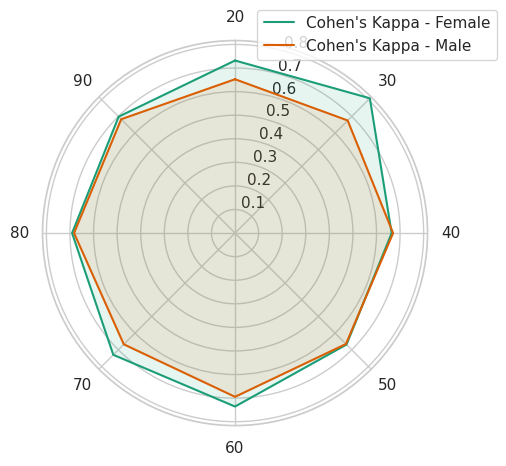

In [209]:
dice_df['Age']=dice_df['Age'].astype(float)
ages = [20,30,40,50,60,70,80,90]
kappa_m = []
kappa_f = []
acc_m = []
acc_f = []

compartments = ['Female','Male']

for a in ages:
    for c in compartments:
        k = dice_df.loc[(dice_df['Age'].between(a-10,a+10))&(dice_df['Sex']==c),'Kappa'].mean()
        a = dice_df.loc[(dice_df['Age'].between(a-10,a+10))&(dice_df['Sex']==c),'Accuracy'].mean()

        if c == 'Female':
            kappa_f.append(k)
            acc_f.append(a)

        if c == 'Male':
            kappa_m.append(k)
            acc_m.append(a)

polar_equity = pd.DataFrame(ages,columns=['Age'])
polar_equity["Cohen's Kappa - Female"]=kappa_f
polar_equity["Cohen's Kappa - Male"]=kappa_m
polar_equity["Accuracy - Female"]=acc_f
polar_equity["Accuracy - Male"]=acc_m
polar_equity
categories = polar_equity['Age']
q1 = polar_equity["Cohen's Kappa - Female"]
q2 = polar_equity["Cohen's Kappa - Male"]
label_loc = np.linspace(start=0, stop=2*np.pi, num=len(q1)+1)

ax=plt.figure(figsize=(5, 5))
ax=plt.subplot(polar=True)

compartment_order = ["Cohen's Kappa - Female","Cohen's Kappa - Male"]
compartment_order_counter=0
for q in [q1, q2]:
    ax.plot(label_loc, np.r_[q, q[0]], label=compartment_order[compartment_order_counter])
    ax.fill(label_loc, np.r_[q, q[0]], alpha=.1,label='_nolegend_')
    compartment_order_counter+=1
# plt.title('TumourSeg: age equity')
lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=categories)
# ax.set(ylim=(0.99,1.))
# ax.set(yticks=yticks)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_rlabel_position(15)

# ax.set_thetagrids(np.degrees(angles), labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
# plt.legend()

# plt.savefig(figures_out+"dice_equitable_age.png",dpi=150,bbox_inches='tight')
# plt.savefig(figures_out+"dice_equitable_age.svg",dpi=150,bbox_inches='tight')

plt.show()

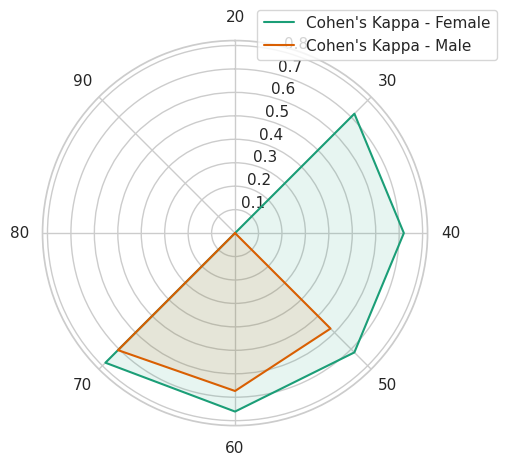

In [261]:

reporters = ['KPB','HH']

ages = [20,30,40,50,60,70,80,90]
rads_ira = pd.DataFrame(ages,columns=['Age'])
rads_ira["Cohen's Kappa"]=0
rads_ira["Cohen's Kappa - Female"]=0
rads_ira["Cohen's Kappa - Male"]=0
rads_ira["Counter"]=0
rads_ira["CounterM"]=0
rads_ira["CounterF"]=0

kappa_rads = []

for d in range(len(duplicate_files)):
    labeler0=[]
    labeler1=[]
    for r in range(len(reporters)):
        
        reporter_vals = duplicates.loc[(duplicates['filename']==duplicate_files[d])&(duplicates['reporter']==reporters[r])].copy().reset_index(drop=True)
        pt_age = dice_df.loc[dice_df['filename']==reporter_vals.iloc[0,0],'Age'].values[0]
        pt_sex = dice_df.loc[dice_df['filename']==reporter_vals.iloc[0,0],'Sex'].values[0]

        reporter_vals.drop(drop_cols,axis=1,inplace=True)
        if r == 0:
            labeler0 = reporter_vals.values[0]
        if r == 1:
            labeler1 = reporter_vals.values[0]

    cks = cohen_kappa_score(labeler0, labeler1,weights='linear')
    rads_ira.loc[rads_ira['Age'].between(pt_age-5,pt_age+5),"Cohen's Kappa"]+=cks
    rads_ira.loc[rads_ira['Age'].between(pt_age-5,pt_age+5),"Counter"]+=1

    if pt_sex == 'Male':
        rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"Cohen's Kappa - Male"]+=cks
        rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"CounterM"]+=1

    if pt_sex == 'Female':
        rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"Cohen's Kappa - Female"]+=cks
        rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"CounterF"]+=1
    
rads_ira["Cohen's Kappa"] = rads_ira["Cohen's Kappa"]/rads_ira['Counter']
rads_ira["Cohen's Kappa - Female"] = rads_ira["Cohen's Kappa - Female"]/rads_ira['CounterF']
rads_ira["Cohen's Kappa - Male"] = rads_ira["Cohen's Kappa - Male"]/rads_ira['CounterM']
rads_ira.fillna(0,inplace=True)

categories = rads_ira['Age']
q1 = rads_ira["Cohen's Kappa - Female"]
q2 = rads_ira["Cohen's Kappa - Male"]
label_loc = np.linspace(start=0, stop=2*np.pi, num=len(q1)+1)

ax=plt.figure(figsize=(5, 5))
ax=plt.subplot(polar=True)

compartment_order = ["Cohen's Kappa - Female","Cohen's Kappa - Male"]
compartment_order_counter=0
for q in [q1, q2]:
    ax.plot(label_loc, np.r_[q, q[0]], label=compartment_order[compartment_order_counter])
    ax.fill(label_loc, np.r_[q, q[0]], alpha=.1,label='_nolegend_')
    compartment_order_counter+=1
# plt.title('TumourSeg: age equity')
lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=categories)
# ax.set(ylim=(0.99,1.))
# ax.set(yticks=yticks)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_rlabel_position(15)

# ax.set_thetagrids(np.degrees(angles), labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.show()

0    20yrs
1    30yrs
2    40yrs
3    50yrs
4    60yrs
5    70yrs
6    80yrs
7    90yrs
Name: Age, dtype: object

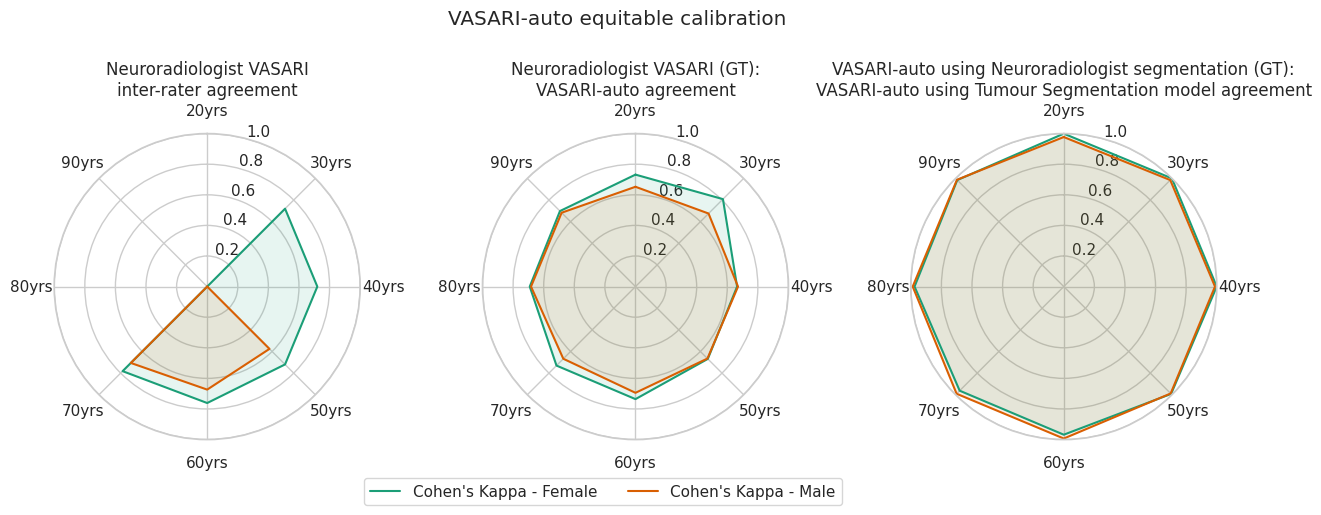

In [283]:
fig = plt.figure(figsize=(15,5))
comparison_order = ['Neuroradiologist VASARI\ninter-rater agreement',
                    'Neuroradiologist VASARI (GT):\nVASARI-auto agreement',
                   'VASARI-auto using Neuroradiologist segmentation (GT):\nVASARI-auto using Tumour Segmentation model agreement']


ax1 = plt.subplot(131,projection = 'polar')

# AX1
reporters = ['KPB','HH']
ages = [20,30,40,50,60,70,80,90]
rads_ira = pd.DataFrame(ages,columns=['Age'])
rads_ira["Cohen's Kappa"]=0
rads_ira["Cohen's Kappa - Female"]=0
rads_ira["Cohen's Kappa - Male"]=0
rads_ira["Counter"]=0
rads_ira["CounterM"]=0
rads_ira["CounterF"]=0

kappa_rads = []

for d in range(len(duplicate_files)):
    labeler0=[]
    labeler1=[]
    for r in range(len(reporters)):
        
        reporter_vals = duplicates.loc[(duplicates['filename']==duplicate_files[d])&(duplicates['reporter']==reporters[r])].copy().reset_index(drop=True)
        pt_age = dice_df.loc[dice_df['filename']==reporter_vals.iloc[0,0],'Age'].values[0]
        pt_sex = dice_df.loc[dice_df['filename']==reporter_vals.iloc[0,0],'Sex'].values[0]

        reporter_vals.drop(drop_cols,axis=1,inplace=True)
        if r == 0:
            labeler0 = reporter_vals.values[0]
        if r == 1:
            labeler1 = reporter_vals.values[0]

    cks = cohen_kappa_score(labeler0, labeler1,weights='linear')
    rads_ira.loc[rads_ira['Age'].between(pt_age-5,pt_age+5),"Cohen's Kappa"]+=cks
    rads_ira.loc[rads_ira['Age'].between(pt_age-5,pt_age+5),"Counter"]+=1

    if pt_sex == 'Male':
        rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"Cohen's Kappa - Male"]+=cks
        rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"CounterM"]+=1

    if pt_sex == 'Female':
        rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"Cohen's Kappa - Female"]+=cks
        rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"CounterF"]+=1
    
rads_ira["Cohen's Kappa"] = rads_ira["Cohen's Kappa"]/rads_ira['Counter']
rads_ira["Cohen's Kappa - Female"] = rads_ira["Cohen's Kappa - Female"]/rads_ira['CounterF']
rads_ira["Cohen's Kappa - Male"] = rads_ira["Cohen's Kappa - Male"]/rads_ira['CounterM']
rads_ira.fillna(0,inplace=True)

categories = rads_ira['Age'].astype(str)+'yrs'
q1 = rads_ira["Cohen's Kappa - Female"]
q2 = rads_ira["Cohen's Kappa - Male"]
label_loc = np.linspace(start=0, stop=2*np.pi, num=len(q1)+1)

compartment_order = ["Cohen's Kappa - Female","Cohen's Kappa - Male"]
compartment_order_counter=0
for q in [q1, q2]:
    ax1.plot(label_loc, np.r_[q, q[0]], label=compartment_order[compartment_order_counter])
    ax1.fill(label_loc, np.r_[q, q[0]], alpha=.1,label='_nolegend_')
    compartment_order_counter+=1
# plt.title('TumourSeg: age equity')
lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=categories)
ax1.set(ylim=(0,1.))
# ax1.set(yticks=yticks)
ax1.set_theta_offset(np.pi / 2)
ax1.set_theta_direction(-1)
ax1.set_rlabel_position(15)
ax1.set_title(comparison_order[0])
# ax1.set(yticks=yticks)

# ax.set_thetagrids(np.degrees(angles), labels)
# ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))



# AX2
ax2 = plt.subplot(132,projection = 'polar')
dice_df['Age']=dice_df['Age'].astype(float)
ages = [20,30,40,50,60,70,80,90]
kappa_m = []
kappa_f = []
acc_m = []
acc_f = []

compartments = ['Female','Male']
for a in ages:
    for c in compartments:
        k = dice_df.loc[(dice_df['Age'].between(a-10,a+10))&(dice_df['Sex']==c),'Kappa'].mean()
        a = dice_df.loc[(dice_df['Age'].between(a-10,a+10))&(dice_df['Sex']==c),'Accuracy'].mean()

        if c == 'Female':
            kappa_f.append(k)
            acc_f.append(a)

        if c == 'Male':
            kappa_m.append(k)
            acc_m.append(a)

polar_equity = pd.DataFrame(ages,columns=['Age'])
polar_equity["Cohen's Kappa - Female"]=kappa_f
polar_equity["Cohen's Kappa - Male"]=kappa_m
polar_equity["Accuracy - Female"]=acc_f
polar_equity["Accuracy - Male"]=acc_m
polar_equity
categories = polar_equity['Age'].astype(str)+'yrs'
q1 = polar_equity["Cohen's Kappa - Female"]
q2 = polar_equity["Cohen's Kappa - Male"]
label_loc = np.linspace(start=0, stop=2*np.pi, num=len(q1)+1)
compartment_order = ["Cohen's Kappa - Female","Cohen's Kappa - Male"]
compartment_order_counter=0
for q in [q1, q2]:
    ax2.plot(label_loc, np.r_[q, q[0]], label=compartment_order[compartment_order_counter])
    ax2.fill(label_loc, np.r_[q, q[0]], alpha=.1,label='_nolegend_')
    compartment_order_counter+=1
# plt.title('TumourSeg: age equity')
lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=categories)
ax2.set(ylim=(0,1.))
# ax2.set(yticks=yticks)
ax2.set_theta_offset(np.pi / 2)
ax2.set_theta_direction(-1)
ax2.set_rlabel_position(15)

# ax.set_thetagrids(np.degrees(angles), labels)
ax2.legend(loc='upper right', bbox_to_anchor=(1.2, -0.1),ncols=2)
ax2.set_title(comparison_order[1])


# # ax3
ax3 = plt.subplot(133,projection = 'polar')
dice_df['Age']=dice_df['Age'].astype(float)
ages = [20,30,40,50,60,70,80,90]
kappa_m = []
kappa_f = []
acc_m = []
acc_f = []

compartments = ['Female','Male']
for a in ages:
    for c in compartments:
        k = dice_df.loc[(dice_df['Age'].between(a-10,a+10))&(dice_df['Sex']==c),'VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model Kappa'].mean()
        a = dice_df.loc[(dice_df['Age'].between(a-10,a+10))&(dice_df['Sex']==c),'Accuracy'].mean()

        if c == 'Female':
            kappa_f.append(k)
            acc_f.append(a)

        if c == 'Male':
            kappa_m.append(k)
            acc_m.append(a)

polar_equity = pd.DataFrame(ages,columns=['Age'])
polar_equity["Cohen's Kappa - Female"]=kappa_f
polar_equity["Cohen's Kappa - Male"]=kappa_m
polar_equity["Accuracy - Female"]=acc_f
polar_equity["Accuracy - Male"]=acc_m
polar_equity
categories = polar_equity['Age'].astype(str)+'yrs'
q1 = polar_equity["Cohen's Kappa - Female"]
q2 = polar_equity["Cohen's Kappa - Male"]
label_loc = np.linspace(start=0, stop=2*np.pi, num=len(q1)+1)
compartment_order = ["Cohen's Kappa - Female","Cohen's Kappa - Male"]
compartment_order_counter=0
for q in [q1, q2]:
    ax3.plot(label_loc, np.r_[q, q[0]], label=compartment_order[compartment_order_counter])
    ax3.fill(label_loc, np.r_[q, q[0]], alpha=.1,label='_nolegend_')
    compartment_order_counter+=1
# plt.title('TumourSeg: age equity')
lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=categories)
ax3.set(ylim=(0,1.))
# ax3.set(yticks=yticks)
ax3.set_theta_offset(np.pi / 2)
ax3.set_theta_direction(-1)
ax3.set_rlabel_position(15)

# ax.set_thetagrids(np.degrees(angles), labels)
# ax3.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
ax3.set_title(comparison_order[2])
# plt.legend()

# plt.savefig(figures_out+"dice_equitable_age.png",dpi=150,bbox_inches='tight')
# plt.savefig(figures_out+"dice_equitable_age.svg",dpi=150,bbox_inches='tight')


# ax3.set_title('Sex',y=1.075)

# ##age calibration
# categories = polar_dice['Age']
# q1 = polar_dice['NET']
# q2 = polar_dice['ET']
# q3 = polar_dice['PS']
# q4 = polar_dice['WT']
# label_loc = np.linspace(start=0, stop=2*np.pi, num=len(q1)+1)

# compartment_order_counter=0
# for q in [q1, q2, q3, q4]:
#     ax4.plot(label_loc, np.r_[q, q[0]], label=compartment_order[compartment_order_counter])
#     ax4.fill(label_loc, np.r_[q, q[0]], alpha=.1,label='_nolegend_')
#     compartment_order_counter+=1
# ax4.set_title('Age (years)')
# lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=categories)
# ax4.set(ylim=(0.99,1.))
# # ax4.set_xticks(labels,fontsize=5)
# ax4.set_theta_offset(np.pi / 2)
# ax4.set_theta_direction(-1)
# ax4.set_rlabel_position(15)
# # ax.set_thetagrids(np.degrees(angles), labels)
# ax4.legend(loc='upper right', bbox_to_anchor=(.65, .5))
# # ax4.set_yticks(size=5)
# # ax4.set_xticks(size=5)


# ax1.set_box_aspect(1)
# ax2.set_box_aspect(1)
# ax3.set_box_aspect(1)
# # ax4.set_box_aspect(1)

# # plt.tight_layout()

plt.subplots_adjust(wspace=0.4)
# plt.subplots_adjust(hspace=0.15)

fig.suptitle("VASARI-auto equitable calibration",y=1.05)

plt.savefig(figures_out+"Figure5.png",dpi=300,bbox_inches='tight')
plt.savefig(figures_out+"Figure5.svg",dpi=300,bbox_inches='tight')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>